In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyproj import Proj, transform
import folium
from folium.plugins import MarkerCluster
from scipy.spatial import KDTree
full_df = pd.read_csv("..\\datasets\\CBS_2021-2023_Full.csv", sep=",")

D:\Users\Olunia\AppData\Local\Temp\ipykernel_41864\2415836925.py:9: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  full_df = pd.read_csv("..\\datasets\\CBS_2021-2023_Full.csv", sep=",")


In [2]:
# Filter rows where end_lat and end_lng have more than 2 decimal places, and end_station_name is NaN
full_df_filtered = full_df[
    (full_df['end_station_name'].isna()) & 
    (full_df['end_lat'].apply(lambda x: len(str(x).split('.')[1]) > 2 if '.' in str(x) else False)) & 
    (full_df['end_lng'].apply(lambda x: len(str(x).split('.')[1]) > 2 if '.' in str(x) else False))
]

# Display the end_lat, end_lng, and end_station_name columns of the filtered rows
full_df_filtered[['end_lat', 'end_lng', 'end_station_name']]



,end_lat,end_lng,end_station_name


In [3]:
elevation = pd.read_csv("..\\src\\elevation_data.csv")

In [4]:
full_df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,5CB9DFCECF79AF84,classic_bike,2021-01-01 00:08:33,2021-01-01 00:33:53,Maine Ave & 9th St SW,31646.0,Rosslyn Metro / Wilson Blvd & Ft Myer Dr,31015.0,38.880440,-77.025236,38.894600,-77.072305,member
1,629E059504606547,electric_bike,2021-01-01 00:13:43,2021-01-01 00:29:34,10th & U St NW,31111.0,NaN,NaN,38.917193,-77.025894,38.960000,-77.020000,casual
2,E74069873161EE33,electric_bike,2021-01-01 00:14:32,2021-01-01 00:28:45,17th & Corcoran St NW,31214.0,14th & Belmont St NW,31119.0,38.912138,-77.038568,38.920870,-77.031691,member
3,91F95E512CABC46A,classic_bike,2021-01-01 00:15:45,2021-01-01 00:21:20,Wilson Blvd. & N. Vermont St.,31926.0,Wilson Blvd. & N. Vermont St.,31926.0,38.879477,-77.114563,38.879477,-77.114563,member
4,DA46A05139C0EA2F,classic_bike,2021-01-01 00:17:46,2021-01-01 00:21:00,11th & Park Rd NW,31651.0,14th & Newton St NW,31649.0,38.931322,-77.028247,38.931991,-77.032956,member


In [4]:
full_df.shape

(10693997, 13)

In [5]:
full_df.duplicated().sum()

0

In [6]:
full_df.isna().sum()

ride_id                    0
rideable_type              0
started_at                 0
ended_at                   0
start_station_name    742776
start_station_id      742776
end_station_name      811282
end_station_id        811282
start_lat                  2
start_lng                  2
end_lat                16765
end_lng                16765
member_casual              0
dtype: int64

In [13]:
full_df[full_df['end_station_id'].isna() & full_df['end_lat'].notna() & full_df['end_lng'].notna()][['end_station_id', 'end_lat', 'end_lng','start_lng']]


,end_station_id,end_lat,end_lng,start_lng
1,NaN,38.96,-77.02,-77.025894
7,NaN,38.90,-77.02,-77.023768
17,NaN,38.93,-77.04,-77.032145
20,NaN,38.99,-77.03,-77.030000
21,NaN,38.92,-77.07,-77.058010
...,...,...,...,...
10693970,NaN,38.90,-77.02,-77.031661
10693977,NaN,38.92,-77.04,-77.020000
10693985,NaN,38.96,-76.98,-77.002654
10693988,NaN,38.93,-77.04,-77.032059


Removing rows where station name and coordinates are missing

In [14]:
full_df[full_df['end_station_id'].isna() & full_df['end_lat'].isna() & full_df['end_lng'].isna()][['end_station_id', 'end_lat', 'end_lng','start_station_name', 'started_at', 'ended_at']]

,end_station_id,end_lat,end_lng,start_station_name,started_at,ended_at
323,NaN,NaN,NaN,Tenleytown / Wisconsin Ave & Albemarle St NW,2021-01-01 09:30:20,2021-01-01 11:21:33
561,NaN,NaN,NaN,Lincoln Memorial,2021-01-01 12:57:44,2021-01-01 16:19:10
3631,NaN,NaN,NaN,Woodglen Dr & Executive Blvd,2021-01-02 14:18:26,2021-01-02 15:39:59
3634,NaN,NaN,NaN,Woodglen Dr & Executive Blvd,2021-01-02 14:18:47,2021-01-02 15:40:08
4170,NaN,NaN,NaN,Columbus Circle / Union Station,2021-01-02 14:55:47,2021-01-02 15:13:20
...,...,...,...,...,...,...
10691132,NaN,NaN,NaN,1st & Q St SW,2023-12-31 15:52:03,2024-01-01 16:51:59
10691183,NaN,NaN,NaN,1st & N St SE,2023-12-31 15:57:04,2024-01-01 16:56:58
10691725,NaN,NaN,NaN,Alabama Ave & Stanton Rd SE / Shops at Park Vi...,2023-12-31 16:47:09,2024-01-01 17:47:02
10693231,NaN,NaN,NaN,22nd St & Constitution Ave NW,2023-12-31 20:33:50,2024-01-01 21:33:36


In [15]:
full_df[full_df['start_station_name'].isna() & full_df['start_lat'].isna() & full_df['start_lng'].isna()][['start_station_name', 'start_lat', 'start_lng']]

,start_station_name,start_lat,start_lng


With ~ (negation):


mask = ~(full_df['start_lat'].isna())
full_df = full_df[mask]
This creates a mask where the rows with non-NaN values in 'start_lat' are True, and those with NaN values are False. You then filter the DataFrame to keep only the non-NaN rows.

Without ~ (no negation):

mask = full_df['start_lat'].isna()
full_df = full_df[~mask]
Without negation, the mask will be True for rows where 'start_lat' is NaN, and False for rows where it's not NaN. The ~mask in the filtering step then negates the mask to select only the non-NaN rows.

In [10]:
mask = ~((full_df['end_station_id'].isna()) & (full_df['end_lat'].isna()) & (full_df['end_lng'].isna()))
full_df = full_df[mask]

# full_df.dropna(subset=['end_station_id', 'end_lat', 'end_lng'], how='all', inplace=True)
# how='all': Drops rows where all of the specified columns have NaN values.
# how='any': Drops rows where any of the specified columns have NaN values

In [11]:
full_df.isna().sum()

ride_id                    0
rideable_type              0
started_at                 0
ended_at                   0
start_station_name    742776
start_station_id      742776
end_station_name      794519
end_station_id        794519
start_lat                  2
start_lng                  2
end_lat                    2
end_lng                    2
member_casual              0
dtype: int64

In [12]:
mask = ~(full_df['start_lat'].isna())
full_df = full_df[mask]

Only stations left that have coordinates but no names:

In [13]:
full_df.isna().sum()

ride_id                    0
rideable_type              0
started_at                 0
ended_at                   0
start_station_name    742776
start_station_id      742776
end_station_name      794519
end_station_id        794519
start_lat                  0
start_lng                  0
end_lat                    0
end_lng                    0
member_casual              0
dtype: int64

In [14]:
# Ensure 'started_at' and 'ended_at' are datetime columns
full_df['started_at'] = pd.to_datetime(full_df['started_at'])
full_df['ended_at'] = pd.to_datetime(full_df['ended_at'])

# Calculate the trip duration in minutes
full_df['trip_duration_minutes'] = (full_df['ended_at'] - full_df['started_at']).dt.total_seconds() / 60

# Filter out trips that are less than 3 minutes
full_df = full_df[full_df['trip_duration_minutes'] >= 3]


## Check if any geographical coordinates without a station name belong to a station or outside the station

The code identifies rows in the data where the starting and ending coordinates are the same, the starting station has a name assigned, while the ending station is missing, and then returns the count of those rows.

In [15]:
# Sprawdź, które wiersze mają równe współrzędne startowe i końcowe
mask_coordinates = (full_df['start_lat'] == full_df['end_lat']) & (full_df['start_lng'] == full_df['end_lng'])

# Sprawdź, które wiersze mają przypisaną nazwę stacji początkowej
mask_station_name = pd.notna(full_df['start_station_id'])

# Sprawdź, które wiersze nie mają przypisanej nazwy stacji końcowej
mask_no_end_station_name = pd.isna(full_df['end_station_id'])

# Znajdź wiersze, które spełniają wszystkie warunki
matching_rows = full_df[mask_coordinates & mask_station_name & mask_no_end_station_name]

# Jeśli takie wiersze istnieją, przypisz nazwę stacji początkowej do stacji końcowej
# df.loc[matching_rows.index, 'end_station_name'] = df.loc[matching_rows.index, 'start_station_name']

# Wyświetl liczbę wierszy, które spełniają warunki oraz zmodyfikowany DataFrame
print(f"Liczba wierszy, które spełniają warunki: {matching_rows.shape[0]}")
# print(df.loc[matching_rows.index, ['start_station_name', 'end_station_name']])


Liczba wierszy, które spełniają warunki: 0


In [16]:
full_df['end_station_name'].value_counts().sum()


9322693

In [17]:
x = full_df[(full_df['start_lat'] < 38.000000) | (full_df['end_lat'] < 38.000000)]
x.shape

(13, 14)

In [18]:
mask = full_df[(full_df['end_station_name'] == 'Motivate Tech Office')]
mask.shape

(12, 14)

In [19]:
full_df[(full_df['start_lat'] < 38.000000) | (full_df['end_lat'] < 38.000000) & (full_df['end_station_name'] != 'Motivate Tech Office')]

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,trip_duration_minutes
2870373,C80E3586C17A6501,classic_bike,2022-02-02 22:49:47,2022-02-03 19:51:49,Maine Ave & 7th St SW,31609.0,NaN,NaN,38.878694,-77.023054,0.0,0.0,member,1262.033333


In [20]:
mask = (full_df['start_lat'] < 38.000000) | (full_df['end_lat'] < 38.000000)
mask &= full_df['end_station_name'] != 'Motivate Tech Office'

# Drop the rows where the condition is True
full_df = full_df[~mask]

In [21]:
full_df = full_df[full_df['end_station_name'] != 'Motivate Tech Office']

In [22]:
dropped_bikes = full_df[
    full_df['end_station_id'].isna() & 
    full_df['end_lat'].notna() & 
    full_df['end_lng'].notna() & 
    (full_df['end_lat'] != 0) & 
    (full_df['end_lng'] != 0)
]

In [23]:
dropped_bikes

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,trip_duration_minutes
1,629E059504606547,electric_bike,2021-01-01 00:13:43,2021-01-01 00:29:34,10th & U St NW,31111.0,NaN,NaN,38.917193,-77.025894,38.96,-77.02,casual,15.850000
7,78894BDABD9F21DD,electric_bike,2021-01-01 00:20:40,2021-01-01 00:35:36,Columbia Rd & Georgia Ave NW,31115.0,NaN,NaN,38.928081,-77.023768,38.90,-77.02,casual,14.933333
17,3F8AFD9540FF8EDB,electric_bike,2021-01-01 00:26:41,2021-01-01 00:30:09,14th & Harvard St NW,31105.0,NaN,NaN,38.926715,-77.032145,38.93,-77.04,member,3.466667
20,997E8E08C493F034,electric_bike,2021-01-01 00:27:18,2021-01-01 00:34:30,NaN,NaN,NaN,NaN,38.990000,-77.030000,38.99,-77.03,member,7.200000
21,F1F87FA560990FC7,electric_bike,2021-01-01 00:28:39,2021-01-01 00:41:31,Connecticut Ave & Newark St NW / Cleveland Park,31305.0,NaN,NaN,38.934253,-77.058010,38.92,-77.07,member,12.866667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10693969,D0915721D57A2DDB,electric_bike,2023-12-31 23:47:39,2023-12-31 23:51:47,Friendship Blvd & Willard Ave,32040.0,NaN,NaN,38.961228,-77.088635,38.96,-77.07,casual,4.133333
10693970,C23F1DB65A85FB04,electric_bike,2023-12-31 23:47:46,2023-12-31 23:59:18,14th & L St NW,31283.0,NaN,NaN,38.903728,-77.031661,38.90,-77.02,member,11.533333
10693977,EA4524CC5F528237,electric_bike,2023-12-31 23:51:14,2023-12-31 23:59:49,NaN,NaN,NaN,NaN,38.910000,-77.020000,38.92,-77.04,member,8.583333
10693985,52DD927885B2A4E9,electric_bike,2023-12-31 23:54:07,2024-01-01 00:01:39,Fort Totten Metro,31515.0,NaN,NaN,38.952364,-77.002654,38.96,-76.98,member,7.533333


In [24]:
# Dodanie kolumny wskazującej, czy rower został porzucony
full_df['was_dropped'] = full_df['end_station_name'].isna()

Visualizing dropped bikes

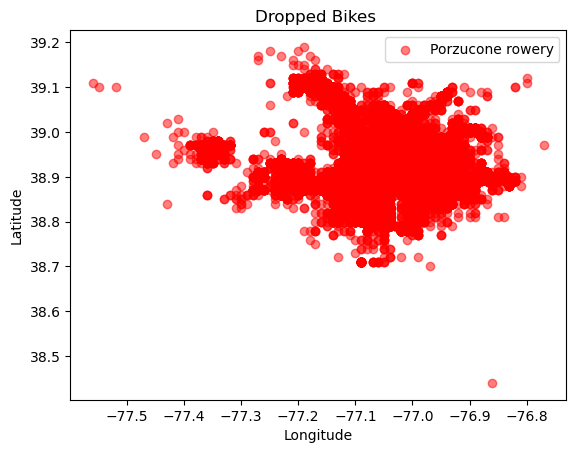

In [25]:
# Tworzymy wykres lokalizacji porzuconych rowerów tylko dla tych stacji, które mają dane topograficzne
plt.scatter(dropped_bikes['end_lng'], dropped_bikes['end_lat'], c='red', label='Porzucone rowery', alpha=0.5)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Dropped Bikes ')
plt.legend()
plt.show()


In [ ]:
from folium.plugins import HeatMap

# Sample data for dropped bikes
dropped_bikes = dropped_bikes[['end_lat', 'end_lng']]

# Create a map centered at Washington DC
map_dc = folium.Map(location=[38.89511, -77.03637], zoom_start=12)

# Convert the data into a list of latitude and longitude pairs
heat_data = [[row['end_lat'], row['end_lng']] for index, row in dropped_bikes.iterrows()]

# Add the heatmap layer
HeatMap(heat_data).add_to(map_dc)

# Display the map
map_dc



In [ ]:
# # Create a map centered on Washington, D.C.
# m = folium.Map(location=[38.9072, -77.0369], zoom_start=12)

# # Add dropped bikes as points
# for lat, lng in zip(dropped_bikes['end_lat'], dropped_bikes['end_lng']):
#     folium.CircleMarker(
#         location=[lat, lng],
#         radius=3,
#         color='red',
#         fill=True,
#         fill_color='red',
#         fill_opacity=0.5
#     ).add_to(m)

# # Display the map
# m


This code identifies stations where bikes were returned, counts the number of bikes left at each station, and displays the top 50 stations with the highest bike returns.

In [ ]:
# Przykładowe dane: full_df z kolumnami: 'start_station_id', 'end_station_id', 'end_lat', 'end_lng'
# Sprawdzamy, gdzie rowery zostały pozostawione (na stacji końcowej)
bike_dropoff = full_df[full_df['end_station_name'].notna()]

# Zliczamy rowery pozostawione na poszczególnych stacjach
returned_bike_counts = bike_dropoff['end_station_name'].value_counts()

# Wyświetlamy stacje z największą liczbą rowerów
print(returned_bike_counts.head(50))


end_station_name
Columbus Circle / Union Station                          99011
New Hampshire Ave & T St NW                              93778
Lincoln Memorial                                         93537
15th & P St NW                                           92961
Jefferson Dr & 14th St SW                                89593
1st & M St NE                                            85930
4th St & Madison Dr NW                                   81070
Massachusetts Ave & Dupont Circle NW                     77208
Smithsonian-National Mall / Jefferson Dr & 12th St SW    76893
5th & K St NW                                            76643
Henry Bacon Dr & Lincoln Memorial Circle NW              74975
Eastern Market Metro / Pennsylvania Ave & 8th St SE      74495
14th & V St NW                                           73052
14th & R St NW                                           67509
8th & O St NW                                            66349
15th & W St NW                        

In [ ]:
elevation

,station_name,latitude,longitude,elevation,elevation_label
0,Maine Ave & 9th St SW,38.880440,-77.025236,3.0,low
1,10th & U St NW,38.917193,-77.025894,31.0,medium
2,17th & Corcoran St NW,38.912138,-77.038568,29.0,medium
3,Wilson Blvd. & N. Vermont St.,38.879477,-77.114563,82.0,high
4,11th & Park Rd NW,38.931322,-77.028247,60.0,medium
...,...,...,...,...,...
854,Old Meadow Rd & Cathy Ln,38.916908,-77.213879,121.0,high
855,Route 29 & Circle Woods Dr,38.869114,-77.271538,102.0,high
856,Prosperity Ave & Avenir Pl,38.881436,-77.230377,119.0,high
857,Kingsbridge Dr & Draper Dr,38.868545,-77.282083,98.0,high


### Tworzenie słownika wysokości stacji  

`zip()` to funkcja w Pythonie, która łączy dwa (lub więcej) iterowalne obiekty w pary. W tym przypadku:  

```python
elevation_dict = dict(zip(elevation['station_name'], elevation['elevation']))


kluczami są nazwy stacji (elevation['station_name']),
wartościami są ich wysokości (elevation['elevation']).
Dlaczego tworzymy słownik?
Słownik pozwala szybko wyszukiwać wysokość dla danej stacji. Zamiast przeszukiwać cały DataFrame dla każdej stacji, możemy po prostu zrobić:

`elevation_dict['Some Station Name']`
co zwróci wysokość tej stacji. To przyspiesza kod i sprawia, że jest bardziej czytelny. 

Dzięki map() nie trzeba robić pętli for ani apply(), co sprawia, że kod jest czytelniejszy i wydajniejszy.

In [ ]:
# Step 1: Create a dictionary to map 'station_name' to 'elevation' from the 'elevation' DataFrame
elevation_dict = dict(zip(elevation['station_name'], elevation['elevation']))

# Step 2: Use the map function to assign elevations to both 'start_station_name' and 'end_station_name' in one go

# Map start_elevation using the elevation_dict
full_df['start_elevation'] = full_df['start_station_name'].map(elevation_dict)

# Map end_elevation using the same elevation_dict
full_df['end_elevation'] = full_df['end_station_name'].map(elevation_dict)

# Print a sample to check
print(full_df[['start_station_name', 'start_elevation', 'end_station_name', 'end_elevation']].head())


              start_station_name  start_elevation  \
0          Maine Ave & 9th St SW              3.0   
1                 10th & U St NW             31.0   
2          17th & Corcoran St NW             29.0   
3  Wilson Blvd. & N. Vermont St.             82.0   
4              11th & Park Rd NW             60.0   

                           end_station_name  end_elevation  
0  Rosslyn Metro / Wilson Blvd & Ft Myer Dr           51.0  
1                                       NaN           61.0  
2                      14th & Belmont St NW           51.0  
3             Wilson Blvd. & N. Vermont St.           82.0  
4                       14th & Newton St NW           62.0  


In [ ]:
full_df = full_df.drop(columns=["ride_id", "start_station_id", "end_station_id"])


In [ ]:
# Calculate the elevation change or inclination
full_df['elevation_change'] = full_df['start_elevation'] - full_df['end_elevation']
print(full_df[['start_station_name', 'start_elevation', 'end_station_name', 'end_elevation', 'elevation_change']].head())


              start_station_name  start_elevation  \
0          Maine Ave & 9th St SW              3.0   
1                 10th & U St NW             31.0   
2          17th & Corcoran St NW             29.0   
3  Wilson Blvd. & N. Vermont St.             82.0   
4              11th & Park Rd NW             60.0   

                           end_station_name  end_elevation  elevation_change  
0  Rosslyn Metro / Wilson Blvd & Ft Myer Dr           51.0             -48.0  
1                                       NaN           61.0             -30.0  
2                      14th & Belmont St NW           51.0             -22.0  
3             Wilson Blvd. & N. Vermont St.           82.0               0.0  
4                       14th & Newton St NW           62.0              -2.0  


In [ ]:
full_df

,rideable_type,started_at,ended_at,start_station_name,end_station_name,start_lat,start_lng,end_lat,end_lng,member_casual,trip_duration_minutes,was_dropped,start_elevation,end_elevation,elevation_change
0,classic_bike,2021-01-01 00:08:33,2021-01-01 00:33:53,Maine Ave & 9th St SW,Rosslyn Metro / Wilson Blvd & Ft Myer Dr,38.880440,-77.025236,38.894600,-77.072305,member,25.333333,False,3.0,51.0,-48.0
1,electric_bike,2021-01-01 00:13:43,2021-01-01 00:29:34,10th & U St NW,NaN,38.917193,-77.025894,38.960000,-77.020000,casual,15.850000,True,31.0,61.0,-30.0
2,electric_bike,2021-01-01 00:14:32,2021-01-01 00:28:45,17th & Corcoran St NW,14th & Belmont St NW,38.912138,-77.038568,38.920870,-77.031691,member,14.216667,False,29.0,51.0,-22.0
3,classic_bike,2021-01-01 00:15:45,2021-01-01 00:21:20,Wilson Blvd. & N. Vermont St.,Wilson Blvd. & N. Vermont St.,38.879477,-77.114563,38.879477,-77.114563,member,5.583333,False,82.0,82.0,0.0
4,classic_bike,2021-01-01 00:17:46,2021-01-01 00:21:00,11th & Park Rd NW,14th & Newton St NW,38.931322,-77.028247,38.931991,-77.032956,member,3.233333,False,60.0,62.0,-2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10693992,classic_bike,2023-12-31 23:58:06,2024-01-01 00:12:29,King St & Peyton St,Market Square / King St & Royal St,38.806002,-77.055911,38.804718,-77.043363,member,14.383333,False,11.0,16.0,-5.0
10693993,electric_bike,2023-12-31 23:58:27,2024-01-01 00:02:28,Eastern Market Metro / Pennsylvania Ave & 8th ...,Lincoln Park / 13th & East Capitol St NE,38.884185,-76.995396,38.890461,-76.988355,member,4.016667,False,21.0,28.0,-7.0
10693994,classic_bike,2023-12-31 23:59:27,2024-01-01 02:09:11,22nd & P ST NW,23rd & E St NW,38.909394,-77.048728,38.896104,-77.049882,casual,129.733333,False,20.0,23.0,-3.0
10693995,classic_bike,2023-12-31 23:59:30,2024-01-01 02:02:07,22nd & P ST NW,22nd & P ST NW,38.909394,-77.048728,38.909394,-77.048728,casual,122.616667,False,20.0,20.0,0.0


In [ ]:
dropped_bikes

,end_lat,end_lng
1,38.96,-77.02
7,38.90,-77.02
17,38.93,-77.04
20,38.99,-77.03
21,38.92,-77.07
...,...,...
10693969,38.96,-77.07
10693970,38.90,-77.02
10693977,38.92,-77.04
10693985,38.96,-76.98


In [ ]:
elevation

,station_name,latitude,longitude,elevation,elevation_label
0,Maine Ave & 9th St SW,38.880440,-77.025236,3.0,low
1,10th & U St NW,38.917193,-77.025894,31.0,medium
2,17th & Corcoran St NW,38.912138,-77.038568,29.0,medium
3,Wilson Blvd. & N. Vermont St.,38.879477,-77.114563,82.0,high
4,11th & Park Rd NW,38.931322,-77.028247,60.0,medium
...,...,...,...,...,...
854,Old Meadow Rd & Cathy Ln,38.916908,-77.213879,121.0,high
855,Route 29 & Circle Woods Dr,38.869114,-77.271538,102.0,high
856,Prosperity Ave & Avenir Pl,38.881436,-77.230377,119.0,high
857,Kingsbridge Dr & Draper Dr,38.868545,-77.282083,98.0,high


In [ ]:
elevation.loc[elevation['station_name'] == 'US Dept of State / Virginia Ave & 21st St NW', 'elevation'] = 15

In [ ]:
elevation.loc[elevation['station_name'] == 'National Harbor Carousel', 'elevation'] = 10

Assign the closest station to dropped bikes - not very exact, becuase lat and lng of dropped bikes is rounded to 2 decimals

In [ ]:
# dropped_bikes_coords = dropped_bikes[['end_lat', 'end_lng']].values  # Want to work with NumPy array, not DF. It makes operations faster.
# station_coords = elevation[['latitude','longitude']].round(2).values
# station_names = elevation['station_name'].tolist()

# # Create a cKDTree for fast nearest neighbor search
# tree = KDTree(station_coords)

# # Find the closest station for each dropped bike
# distances, indices = tree.query(dropped_bikes_coords)

# #Convert the distances from degrees to meters
# degree_to_meter = 111320
# distances_in_meters = distances[0] * degree_to_meter  # Convert distances to meters

# # Get the station names corresponding to the closest stations
# closest_stations = [station_names[i] for i in indices]

# # Add the closest station names and distances to the dropped_bikes_df
# dropped_bikes['closest_station'] = closest_stations
# dropped_bikes['distance_to_station'] = distances

# # Print the result (dropped bikes with their closest stations)
# dropped_bikes= dropped_bikes[['end_lat', 'end_lng', 'closest_station', 'distance_to_station']]
# dropped_bikes[dropped_bikes['distance_to_station'] == 0]

In [ ]:
# # Conversion factor from degrees to meters
# degree_to_meter = 111320

# # Convert 'distance_to_station' from degrees to meters
# dropped_bikes['distance_to_station_meters'] = dropped_bikes['distance_to_station'] * degree_to_meter
# dropped_bikes['distance_to_station_meters'] = dropped_bikes['distance_to_station_meters'].round(2)

# # Display the updated DataFrame with distances in meters
# dropped_bikes[['end_lat', 'end_lng', 'closest_station', 'distance_to_station_meters']]
# dropped_bikes[(dropped_bikes["distance_to_station_meters"] != 0)]


In [ ]:
full_df[(full_df['start_station_name'].isna()) & (full_df['rideable_type'] == "electric_bike")]


,rideable_type,started_at,ended_at,start_station_name,end_station_name,start_lat,start_lng,end_lat,end_lng,member_casual,trip_duration_minutes,was_dropped,start_elevation,end_elevation,elevation_change
5,electric_bike,2021-01-01 00:18:16,2021-01-01 00:29:05,NaN,Georgia Ave & Kennedy St NW,38.93,-77.03,38.956738,-77.027940,casual,10.816667,False,61.0,77.0,-16.0
20,electric_bike,2021-01-01 00:27:18,2021-01-01 00:34:30,NaN,NaN,38.99,-77.03,38.990000,-77.030000,member,7.200000,True,61.0,61.0,0.0
37,electric_bike,2021-01-01 00:50:13,2021-01-01 00:57:14,NaN,NaN,38.95,-77.03,38.930000,-77.040000,casual,7.016667,True,61.0,61.0,0.0
49,electric_bike,2021-01-01 01:01:17,2021-01-01 01:42:34,NaN,Oklahoma Ave & Benning Rd NE,38.92,-76.99,38.897472,-76.969465,casual,41.283333,False,61.0,10.0,51.0
52,electric_bike,2021-01-01 01:02:51,2021-01-01 01:16:53,NaN,Connecticut & Nebraska Ave NW,38.91,-77.05,38.954972,-77.069952,member,14.033333,False,61.0,98.0,-37.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10693951,electric_bike,2023-12-31 23:41:46,2023-12-31 23:47:06,NaN,NaN,38.94,-77.03,38.940000,-77.020000,casual,5.333333,True,61.0,61.0,0.0
10693955,electric_bike,2023-12-31 23:43:05,2023-12-31 23:46:24,NaN,NaN,38.94,-77.03,38.940000,-77.020000,casual,3.316667,True,61.0,61.0,0.0
10693961,electric_bike,2023-12-31 23:45:13,2024-01-01 00:02:39,NaN,11th & M St NW,38.88,-77.03,38.905578,-77.027313,casual,17.433333,False,61.0,35.0,26.0
10693965,electric_bike,2023-12-31 23:46:57,2024-01-01 00:03:20,NaN,14th St & Spring Rd NW,38.91,-77.04,38.937500,-77.032800,member,16.383333,False,61.0,53.0,8.0


Seems like almost 750000 electric bike dont have start station name, why?

In [ ]:
full_df = full_df.dropna(subset=['start_station_name', 'end_station_name'])

In [ ]:
full_df.shape

(9031235, 15)

In [ ]:
full_df.head()

,rideable_type,started_at,ended_at,start_station_name,end_station_name,start_lat,start_lng,end_lat,end_lng,member_casual,trip_duration_minutes,was_dropped,start_elevation,end_elevation,elevation_change
0,classic_bike,2021-01-01 00:08:33,2021-01-01 00:33:53,Maine Ave & 9th St SW,Rosslyn Metro / Wilson Blvd & Ft Myer Dr,38.880440,-77.025236,38.894600,-77.072305,member,25.333333,False,3.0,51.0,-48.0
2,electric_bike,2021-01-01 00:14:32,2021-01-01 00:28:45,17th & Corcoran St NW,14th & Belmont St NW,38.912138,-77.038568,38.920870,-77.031691,member,14.216667,False,29.0,51.0,-22.0
3,classic_bike,2021-01-01 00:15:45,2021-01-01 00:21:20,Wilson Blvd. & N. Vermont St.,Wilson Blvd. & N. Vermont St.,38.879477,-77.114563,38.879477,-77.114563,member,5.583333,False,82.0,82.0,0.0
4,classic_bike,2021-01-01 00:17:46,2021-01-01 00:21:00,11th & Park Rd NW,14th & Newton St NW,38.931322,-77.028247,38.931991,-77.032956,member,3.233333,False,60.0,62.0,-2.0
6,classic_bike,2021-01-01 00:19:06,2021-01-01 00:36:28,Bladensburg Rd & Benning Rd NE,Good Hope Rd & MLK Ave SE,38.900413,-76.982872,38.867373,-76.988039,casual,17.366667,False,11.0,12.0,-1.0


In [ ]:
# Define the classify_elevation function
def classify_elevation(elevation):
    if elevation < 20:
        return 'low'
    elif elevation <= 70:
        return 'medium'
    else:
        return 'high'

# Apply classify_elevation to both start_elevation and end_elevation
full_df['start_elevation_label'] = full_df['start_elevation'].apply(classify_elevation)
full_df['end_elevation_label'] = full_df['end_elevation'].apply(classify_elevation)

# Print a sample to check the new labels
print(full_df[['start_elevation', 'start_elevation_label', 'end_elevation', 'end_elevation_label']].head())


D:\Users\Olunia\AppData\Local\Temp\ipykernel_15328\3992885682.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_df['start_elevation_label'] = full_df['start_elevation'].apply(classify_elevation)


   start_elevation start_elevation_label  end_elevation end_elevation_label
0              3.0                   low           51.0              medium
2             29.0                medium           51.0              medium
3             82.0                  high           82.0                high
4             60.0                medium           62.0              medium
6             11.0                   low           12.0                 low


D:\Users\Olunia\AppData\Local\Temp\ipykernel_15328\3992885682.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_df['end_elevation_label'] = full_df['end_elevation'].apply(classify_elevation)


In [ ]:
full_df['start_elevation_label'].value_counts()

start_elevation_label
medium    5444779
low       2956279
high       630177
Name: count, dtype: int64

In [ ]:
full_df['end_elevation_label'].value_counts()

end_elevation_label
medium    5358022
low       3130566
high       542647
Name: count, dtype: int64

In [ ]:
full_df[(full_df['start_elevation_label'] == 'high')]

,rideable_type,started_at,ended_at,start_station_name,end_station_name,start_lat,start_lng,end_lat,end_lng,member_casual,trip_duration_minutes,was_dropped,start_elevation,end_elevation,elevation_change,start_elevation_label,end_elevation_label
3,classic_bike,2021-01-01 00:15:45,2021-01-01 00:21:20,Wilson Blvd. & N. Vermont St.,Wilson Blvd. & N. Vermont St.,38.879477,-77.114563,38.879477,-77.114563,member,5.583333,False,82.0,82.0,0.0,high,high
74,classic_bike,2021-01-01 01:22:31,2021-01-01 01:27:31,Virginia Square Metro / Monroe St & 9th St N,Fairfax Dr & Wilson Blvd,38.882788,-77.103148,38.885801,-77.097745,member,5.000000,False,90.0,79.0,11.0,high,high
75,classic_bike,2021-01-01 01:23:43,2021-01-01 01:36:14,15th St & N Scott St,M St & Pennsylvania Ave NW,38.890540,-77.080950,38.905126,-77.056887,casual,12.516667,False,79.0,17.0,62.0,high,low
135,classic_bike,2021-01-01 02:46:07,2021-01-01 03:25:40,Fort Totten Metro,West Hyattsville Metro,38.952369,-77.002721,38.955349,-76.968084,casual,39.550000,False,71.0,10.0,61.0,high,low
136,classic_bike,2021-01-01 02:49:05,2021-01-01 03:00:12,Fairfax Dr & N Randolph St,Carlin Springs Rd & N Thomas St,38.882629,-77.109366,38.876695,-77.112982,member,11.116667,False,86.0,89.0,-3.0,high,high
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10693839,electric_bike,2023-12-31 23:13:24,2023-12-31 23:25:30,39th & Veazey St NW,Wisconsin Ave & O St NW,38.943833,-77.077085,38.908490,-77.063586,member,12.100000,False,118.0,32.0,86.0,high,medium
10693841,electric_bike,2023-12-31 23:13:45,2023-12-31 23:18:43,Friendship Hts Metro / Wisconsin Ave & Wiscons...,Connecticut Ave & McKinley St NW,38.961758,-77.085997,38.964544,-77.075135,member,4.966667,False,94.0,100.0,-6.0,high,high
10693909,electric_bike,2023-12-31 23:33:52,2023-12-31 23:55:51,Fairfax Dr & N Taylor St,8th Rd & S Frederick St,38.882387,-77.112850,38.857049,-77.116339,member,21.983333,False,96.0,76.0,20.0,high,high
10693942,classic_bike,2023-12-31 23:39:53,2023-12-31 23:44:28,Fort Totten Metro,New Hampshire & Gallatin St NW,38.952369,-77.002721,38.951596,-77.012808,casual,4.583333,False,71.0,77.0,-6.0,high,high


In [ ]:
full_df[(full_df['end_elevation_label'] == 'high')& (full_df['start_elevation_label'] == 'low')]

,rideable_type,started_at,ended_at,start_station_name,end_station_name,start_lat,start_lng,end_lat,end_lng,member_casual,trip_duration_minutes,was_dropped,start_elevation,end_elevation,elevation_change,start_elevation_label,end_elevation_label
88,electric_bike,2021-01-01 01:46:12,2021-01-01 02:14:07,6th & K St NE,Georgia Ave & Piney Branch Rd NW,38.903019,-76.998390,38.967550,-77.027974,member,27.916667,False,13.0,91.0,-78.0,low,high
402,classic_bike,2021-01-01 10:31:23,2021-01-01 11:09:56,Hains Point/Buckeye & Ohio Dr SW,39th & Calvert St NW / Stoddert,38.878433,-77.030230,38.922649,-77.077271,member,38.550000,False,2.0,95.0,-93.0,low,high
972,electric_bike,2021-01-02 00:48:04,2021-01-02 01:14:17,11th & H St NE,Georgia Ave & Piney Branch Rd NW,38.899989,-76.991409,38.967548,-77.027991,member,26.216667,False,14.0,91.0,-77.0,low,high
1440,classic_bike,2021-01-02 10:29:16,2021-01-02 12:33:03,Anacostia Metro,Bethesda Ave & Arlington Rd,38.862669,-76.994637,38.981103,-77.097426,casual,123.783333,False,12.0,96.0,-84.0,low,high
1449,classic_bike,2021-01-02 10:31:22,2021-01-02 12:33:06,Anacostia Metro,Bethesda Ave & Arlington Rd,38.862669,-76.994637,38.981103,-77.097426,casual,121.733333,False,12.0,96.0,-84.0,low,high
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10690333,classic_bike,2023-12-31 14:40:09,2023-12-31 15:23:52,S Arlington Mill Dr & Campbell Ave,Wilson Blvd & N Illinois St,38.842320,-77.089555,38.876528,-77.127120,member,43.716667,False,17.0,87.0,-70.0,low,high
10690347,classic_bike,2023-12-31 14:41:16,2023-12-31 15:24:01,S Arlington Mill Dr & Campbell Ave,Wilson Blvd & N Illinois St,38.842320,-77.089555,38.876528,-77.127120,member,42.750000,False,17.0,87.0,-70.0,low,high
10690726,classic_bike,2023-12-31 15:17:45,2023-12-31 16:26:13,8th & H St NW,Bethesda Ave & Arlington Rd,38.899700,-77.023086,38.981103,-77.097426,member,68.466667,False,18.0,96.0,-78.0,low,high
10691076,electric_bike,2023-12-31 15:47:14,2023-12-31 17:27:29,M St & Pennsylvania Ave NW,N Pershing Dr & N George Mason Dr,38.905113,-77.056936,38.871822,-77.107906,casual,100.250000,False,17.0,83.0,-66.0,low,high


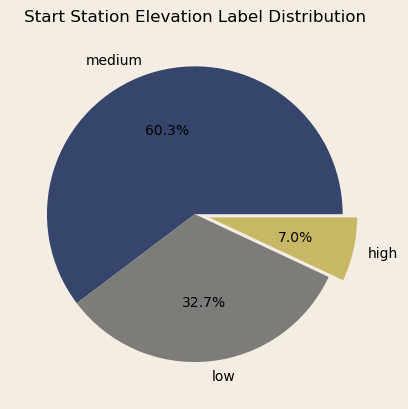

In [ ]:
import matplotlib.pyplot as plt

# Calculate the distribution of the 'start_elevation_label' column
elevation_counts = full_df['start_elevation_label'].value_counts()

# Check if we have exactly 3 unique labels
labels = elevation_counts.index.tolist()

# Create the explode list with the same length as the number of labels
# Default to no explosion, but we make the 'High' label explode slightly
explode = [0.1 if label == 'high' else 0 for label in labels]

# Create the pie chart
fig, ax = plt.subplots()
colors = plt.cm.cividis([0.2, 0.5, 0.8][:len(labels)])  # Ensure the color list matches the number of labels
ax.pie(elevation_counts, explode=explode, labels=labels, autopct='%1.1f%%', colors=colors)

# Set title and background colors
ax.set_title("Start Station Elevation Label Distribution")
fig.patch.set_facecolor('#f3ede3')
ax.set_facecolor("#f3ede3")

# Show the plot
plt.show()


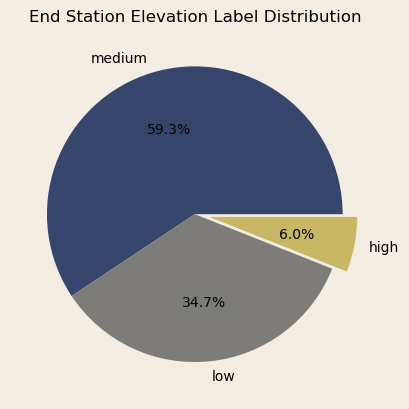

In [ ]:
import matplotlib.pyplot as plt

# Calculate the distribution of the 'start_elevation_label' column
elevation_counts = full_df['end_elevation_label'].value_counts()

# Check if we have exactly 3 unique labels
labels = elevation_counts.index.tolist()

# Create the explode list with the same length as the number of labels
# Default to no explosion, but we make the 'High' label explode slightly
explode = [0.1 if label == 'high' else 0 for label in labels]

# Create the pie chart
fig, ax = plt.subplots()
colors = plt.cm.cividis([0.2, 0.5, 0.8][:len(labels)])  # Ensure the color list matches the number of labels
ax.pie(elevation_counts, explode=explode, labels=labels, autopct='%1.1f%%', colors=colors)

# Set title and background colors
ax.set_title("End Station Elevation Label Distribution")
fig.patch.set_facecolor('#f3ede3')
ax.set_facecolor("#f3ede3")

# Show the plot
plt.show()


In [ ]:
full_df[full_df['rideable_type'] == 'docked_bike']

,rideable_type,started_at,ended_at,start_station_name,end_station_name,start_lat,start_lng,end_lat,end_lng,member_casual,trip_duration_minutes,was_dropped,start_elevation,end_elevation,elevation_change,start_elevation_label,end_elevation_label
8,docked_bike,2021-01-01 00:21:19,2021-01-01 00:33:31,15th & F St NE,1st & M St SE,38.897195,-76.983575,38.876893,-77.006072,casual,12.200000,False,18.0,8.0,10.0,low,low
18,docked_bike,2021-01-01 00:26:51,2021-01-01 00:47:48,Henry Bacon Dr & Lincoln Memorial Circle NW,14th St & New York Ave NW,38.890539,-77.049383,38.899632,-77.031686,casual,20.950000,False,11.0,42.0,-31.0,low,medium
35,docked_bike,2021-01-01 00:47:55,2021-01-01 03:04:53,12th & L St NW,7th & K St NW,38.903819,-77.028400,38.902674,-77.021392,casual,136.966667,False,39.0,20.0,19.0,medium,medium
44,docked_bike,2021-01-01 00:59:41,2021-01-01 01:27:52,Thomas Circle,Thomas Circle,38.905900,-77.032500,38.905900,-77.032500,casual,28.183333,False,36.0,36.0,0.0,medium,medium
45,docked_bike,2021-01-01 00:59:44,2021-01-01 01:27:55,Thomas Circle,Thomas Circle,38.905900,-77.032500,38.905900,-77.032500,casual,28.183333,False,36.0,36.0,0.0,medium,medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9301715,docked_bike,2023-09-13 10:52:36,2023-09-13 13:16:46,19th St & Constitution Ave NW,Smithsonian-National Mall / Jefferson Dr & 12t...,38.892212,-77.043074,38.888774,-77.028694,casual,144.166667,False,11.0,13.0,-2.0,low,low
9301718,docked_bike,2023-09-13 10:52:46,2023-09-13 13:16:24,19th St & Constitution Ave NW,Smithsonian-National Mall / Jefferson Dr & 12t...,38.892212,-77.043074,38.888774,-77.028694,casual,143.633333,False,11.0,13.0,-2.0,low,low
9301744,docked_bike,2023-09-13 10:54:27,2023-09-13 13:16:05,19th St & Constitution Ave NW,Smithsonian-National Mall / Jefferson Dr & 12t...,38.892212,-77.043074,38.888774,-77.028694,casual,141.633333,False,11.0,13.0,-2.0,low,low
9302077,docked_bike,2023-09-13 11:27:38,2023-09-13 12:32:47,19th St & Constitution Ave NW,3rd St & Pennsylvania Ave SE,38.892212,-77.043074,38.887378,-77.001955,casual,65.150000,False,11.0,30.0,-19.0,low,medium


rideable_type
classic_bike     382137
electric_bike    133247
docked_bike       27263
Name: count, dtype: int64


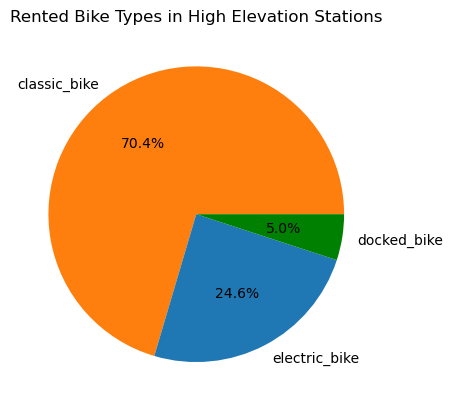

In [ ]:
# Filter the dataset to include only rows with high elevation
high_elevation_bikes = full_df[full_df['end_elevation_label'] == 'high']

# Check the distribution of bike types for high elevation stations
bike_type_counts = high_elevation_bikes['rideable_type'].value_counts()

# Print the results
print(bike_type_counts)

# Optionally, plot a pie chart to visualize the distribution
fig, ax = plt.subplots()
ax.pie(bike_type_counts, labels=bike_type_counts.index, autopct='%1.1f%%', colors=['#ff7f0e', '#1f77b4','green'])
ax.set_title("Rented Bike Types in High Elevation Stations")
plt.show()


In [ ]:
full_df[(full_df['end_elevation_label'] == 'high')][['end_station_name','end_elevation_label']]

,end_station_name,end_elevation_label
3,Wilson Blvd. & N. Vermont St.,high
74,Fairfax Dr & Wilson Blvd,high
88,Georgia Ave & Piney Branch Rd NW,high
106,Lee Hwy & N Adams St,high
136,Carlin Springs Rd & N Thomas St,high
...,...,...
10693813,Connecticut & Nebraska Ave NW,high
10693841,Connecticut Ave & McKinley St NW,high
10693909,8th Rd & S Frederick St,high
10693942,New Hampshire & Gallatin St NW,high


In [ ]:
routes = full_df[full_df['start_station_name'] != full_df['end_station_name']]
# Zliczanie par stacji (trasy)
routes_counts = routes.groupby(['start_station_name', 'end_station_name']).size()

# Sortowanie tras od najczęściej uczęszczanych
top_routes = routes_counts.sort_values(ascending=False)

# Wyświetlenie 5 najczęściej uczęszczanych tras
top_routes= top_routes.head(10)


In [ ]:
routes = routes[~routes['start_elevation'].isna()]
routes = routes[~routes['end_elevation'].isna()]
routes.isna().sum()

rideable_type            0
started_at               0
ended_at                 0
start_station_name       0
end_station_name         0
start_lat                0
start_lng                0
end_lat                  0
end_lng                  0
member_casual            0
trip_duration_minutes    0
was_dropped              0
start_elevation          0
end_elevation            0
elevation_change         0
start_elevation_label    0
end_elevation_label      0
dtype: int64

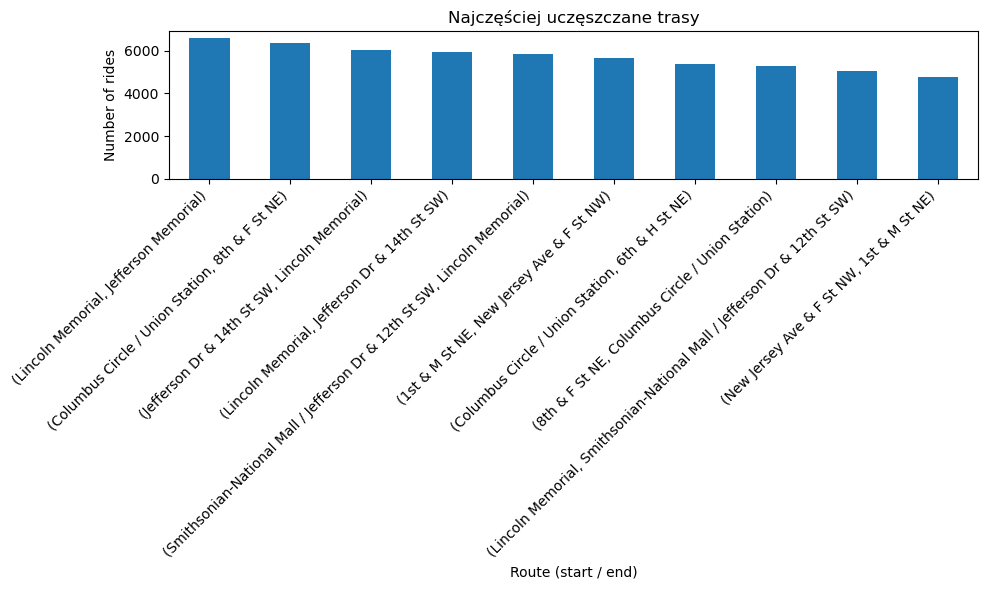

In [ ]:
# Tworzenie wykresu
top_routes.plot(kind='bar', figsize=(10, 6))

# Tytuł wykresu
plt.title('Najczęściej uczęszczane trasy')

# Etykiety osi
plt.xlabel('Route (start / end)')
plt.ylabel('Number of rides')

# Dostosowanie widoczności etykiet na osi X
plt.xticks(rotation=45, ha='right')

# Wyświetlenie wykresu
plt.tight_layout()
plt.show()


### Calculate Gradient (Angle of Inclanation % )
0%: A flat road
1-3%: Slightly uphill but not particularly challenging. A bit like riding into the wind.
4-6%: A manageable gradient that can cause fatigue over long periods.
7-9%: Starting to become uncomfortable for seasoned riders, and very challenging for new climbers.
10%-15%: A painful gradient, especially if maintained for any length of time
16%+: Very challenging for riders of all abilities. Maintaining this sort of incline for any length of time is very painful.

### Assing elevation to each station

In [ ]:
elevation

,station_name,latitude,longitude,elevation,elevation_label
0,Maine Ave & 9th St SW,38.880440,-77.025236,3.0,low
1,10th & U St NW,38.917193,-77.025894,31.0,medium
2,17th & Corcoran St NW,38.912138,-77.038568,29.0,medium
3,Wilson Blvd. & N. Vermont St.,38.879477,-77.114563,82.0,high
4,11th & Park Rd NW,38.931322,-77.028247,60.0,medium
...,...,...,...,...,...
854,Old Meadow Rd & Cathy Ln,38.916908,-77.213879,121.0,high
855,Route 29 & Circle Woods Dr,38.869114,-77.271538,102.0,high
856,Prosperity Ave & Avenir Pl,38.881436,-77.230377,119.0,high
857,Kingsbridge Dr & Draper Dr,38.868545,-77.282083,98.0,high


### Merge
Merge is a function in pandas used to join two DataFrames based on common columns. 
I want to merge full_df and dropped_bikes basen on the end lat and end lng

In [ ]:
# print(f"full_df: {full_df.shape}")  # (rows, columns)
# print(f"dropped_bikes_closest_station: {dropped_bikes_closest_station.shape}")

### <sub>Updating the 'end_station_name' in full_df:</sub>

We are updating the `end_station_name` column in the `full_df` DataFrame. Only the rows where the condition is `True` will be updated. Specifically, this applies to rows where:
- `end_station_name` is missing (NaN).
- Both `end_lat` and `end_lng` are not missing (not NaN).

### <sub> .apply() Function: </sub>

The `.apply()` function is applied row-wise (because `axis=1`). It will take each row and pass it into the lambda function to generate the station name.

### <sub>lambda x: coord_to_station.get(tuple(x), np.nan)</sub>
- Converts `end_lat` and `end_lng` into a tuple: `(end_lat, end_lng)`.
- Example: `end_lat = 38.907`, `end_lng = -77.036` → `(38.907, -77.036)`.

### <sub>coord_to_station.get(tuple(x), np.nan)</sub>
- Looks for the tuple `(end_lat, end_lng)` in the `coord_to_station` dictionary.
  - If found, returns the station name.
  - If not found, returns `np.nan`.



In [ ]:
type(full_df)

pandas.core.frame.DataFrame

In [ ]:
if 2870373 in full_df.index:
    full_df.drop(2870373, inplace=True)

In [ ]:
full_df[full_df['end_station_name'].isna() & 
        full_df['end_lat'].notna() & 
        full_df['end_lng'].notna() &
        (full_df['end_lat'] != 38.93)][['end_station_name', 'end_lat', 'end_lng', 'start_lng']]

,end_station_name,end_lat,end_lng,start_lng


In [ ]:
import random

# Coordinates for the special points
special_coords = [(38.98, -77.03)]

# Station names to assign to the special coordinates
special_station_names = ['14th & Otis Pl NW', '11th & Park Rd NW']

# Identify rows in full_df with the special coordinates
special_condition = (full_df['end_lat'] == 38.93) & (full_df['end_lng'] == -77.03)

# Randomly assign one of the two station names to these rows
full_df.loc[special_condition, 'end_station_name'] = [
    random.choice(special_station_names) for _ in range(special_condition.sum())
]

# Check how many of the rows were updated
updated_rows = full_df[special_condition]
updated_rows[['end_station_name', 'end_lat', 'end_lng', 'start_lng']]


,end_station_name,end_lat,end_lng,start_lng


In [ ]:
# Filter rows where 'end_lat' is 38.93 and check if 'end_station_id' is NaN
check_38_93_lat = full_df[(full_df['end_lat'] == 38.93) & full_df['end_station_name'].isna()]

# Show the result to see how many such rows exist
check_38_93_lat[['end_station_name', 'end_lat', 'end_lng', 'start_lng']]


,end_station_name,end_lat,end_lng,start_lng


#### Calculate the Haverine distance

In [ ]:
full_df.columns

Index(['rideable_type', 'started_at', 'ended_at', 'start_station_name',
       'end_station_name', 'start_lat', 'start_lng', 'end_lat', 'end_lng',
       'member_casual', 'trip_duration_minutes', 'was_dropped',
       'start_elevation', 'end_elevation', 'elevation_change',
       'start_elevation_label', 'end_elevation_label'],
      dtype='object')

In [ ]:
def haversine_vectorized(lat1, lon1, lat2, lon2):
    # Convert degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    r = 6371000  # Radius of Earth in meters
    return r * c  # Distance in meters

# Calculate distances for all rows at once (vectorized)
full_df['distance_meters'] = haversine_vectorized(
    full_df['start_lat'], full_df['start_lng'], full_df['end_lat'], full_df['end_lng']
)

# Display the DataFrame with distances
print(full_df[['start_lat', 'start_lng', 'end_lat', 'end_lng', 'distance_meters']])

          start_lat  start_lng    end_lat    end_lng  distance_meters
0         38.880440 -77.025236  38.894600 -77.072305      4367.592696
2         38.912138 -77.038568  38.920870 -77.031691      1138.842581
3         38.879477 -77.114563  38.879477 -77.114563         0.000000
4         38.931322 -77.028247  38.931991 -77.032956       414.049529
6         38.900413 -76.982872  38.867373 -76.988039      3701.002226
...             ...        ...        ...        ...              ...
10693991  38.884095 -76.995234  38.890461 -76.988355       924.983952
10693992  38.806002 -77.055911  38.804718 -77.043363      1096.641932
10693993  38.884185 -76.995396  38.890461 -76.988355       926.459560
10693994  38.909394 -77.048728  38.896104 -77.049882      1481.150682
10693995  38.909394 -77.048728  38.909394 -77.048728         0.000000

[9031235 rows x 5 columns]


D:\Users\Olunia\AppData\Local\Temp\ipykernel_15328\1868883439.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_df['distance_meters'] = haversine_vectorized(


In [ ]:
routes.head()

,rideable_type,started_at,ended_at,start_station_name,end_station_name,start_lat,start_lng,end_lat,end_lng,member_casual,trip_duration_minutes,was_dropped,start_elevation,end_elevation,elevation_change,start_elevation_label,end_elevation_label
0,classic_bike,2021-01-01 00:08:33,2021-01-01 00:33:53,Maine Ave & 9th St SW,Rosslyn Metro / Wilson Blvd & Ft Myer Dr,38.880440,-77.025236,38.894600,-77.072305,member,25.333333,False,3.0,51.0,-48.0,low,medium
2,electric_bike,2021-01-01 00:14:32,2021-01-01 00:28:45,17th & Corcoran St NW,14th & Belmont St NW,38.912138,-77.038568,38.920870,-77.031691,member,14.216667,False,29.0,51.0,-22.0,medium,medium
4,classic_bike,2021-01-01 00:17:46,2021-01-01 00:21:00,11th & Park Rd NW,14th & Newton St NW,38.931322,-77.028247,38.931991,-77.032956,member,3.233333,False,60.0,62.0,-2.0,medium,medium
6,classic_bike,2021-01-01 00:19:06,2021-01-01 00:36:28,Bladensburg Rd & Benning Rd NE,Good Hope Rd & MLK Ave SE,38.900413,-76.982872,38.867373,-76.988039,casual,17.366667,False,11.0,12.0,-1.0,low,low
8,docked_bike,2021-01-01 00:21:19,2021-01-01 00:33:31,15th & F St NE,1st & M St SE,38.897195,-76.983575,38.876893,-77.006072,casual,12.200000,False,18.0,8.0,10.0,low,low


Drop distance 0 

In [ ]:
routes = full_df[full_df['start_station_name'] != full_df['end_station_name']]

In [ ]:
routes = routes[~routes['start_elevation'].isna()]
routes = routes[~routes['end_elevation'].isna()]
routes.isna().sum()

rideable_type            0
started_at               0
ended_at                 0
start_station_name       0
end_station_name         0
start_lat                0
start_lng                0
end_lat                  0
end_lng                  0
member_casual            0
trip_duration_minutes    0
was_dropped              0
start_elevation          0
end_elevation            0
elevation_change         0
start_elevation_label    0
end_elevation_label      0
distance_meters          0
dtype: int64

In [ ]:
routes = routes[routes['distance_meters'] != 0]

In [ ]:
# Step 1: Compute elevation change
routes['elevation_change'] = routes['end_elevation'] - routes['start_elevation']

# Step 2: Avoid division by zero
routes['distance_meters'] = routes['distance_meters'].replace(0, 0.01)  # Replace 0 with 0.01 to prevent errors

# Step 3: Compute inclination percentage
routes['inclination_percent'] = (routes['elevation_change'] / routes['distance_meters']) * 100

# Step 4: Display the result
print(routes[['start_station_name', 'end_station_name', 'elevation_change', 'distance_meters', 'inclination_percent']].head())


               start_station_name                          end_station_name  \
0           Maine Ave & 9th St SW  Rosslyn Metro / Wilson Blvd & Ft Myer Dr   
2           17th & Corcoran St NW                      14th & Belmont St NW   
4               11th & Park Rd NW                       14th & Newton St NW   
6  Bladensburg Rd & Benning Rd NE                 Good Hope Rd & MLK Ave SE   
8                  15th & F St NE                             1st & M St SE   

   elevation_change  distance_meters  inclination_percent  
0              48.0      4367.592696             1.099004  
2              22.0      1138.842581             1.931786  
4               2.0       414.049529             0.483034  
6               1.0      3701.002226             0.027020  
8             -10.0      2981.222620            -0.335433  


In [ ]:
# Define inclination categories
def categorize_inclination(inc):
    if 0 <= inc < 2:
        return "A flat road"
    elif 2 <= inc <= 4:
        return "Moderate Uphill"
    elif inc < 0:
        return "Downhill"
    elif inc >=4:
        return "Steep Uphill"

# Apply function to create a new column
routes['inclination_category'] = routes['inclination_percent'].apply(categorize_inclination)

# Display results
routes[['start_station_name', 'end_station_name', 'inclination_percent', 'inclination_category']]


,start_station_name,end_station_name,inclination_percent,inclination_category
0,Maine Ave & 9th St SW,Rosslyn Metro / Wilson Blvd & Ft Myer Dr,1.099004,A flat road
2,17th & Corcoran St NW,14th & Belmont St NW,1.931786,A flat road
4,11th & Park Rd NW,14th & Newton St NW,0.483034,A flat road
6,Bladensburg Rd & Benning Rd NE,Good Hope Rd & MLK Ave SE,0.027020,A flat road
8,15th & F St NE,1st & M St SE,-0.335433,Downhill
...,...,...,...,...
10693990,18th & New Hampshire Ave NW,17th & K St NW,0.101450,A flat road
10693991,Eastern Market Metro / Pennsylvania Ave & 8th ...,Lincoln Park / 13th & East Capitol St NE,0.756770,A flat road
10693992,King St & Peyton St,Market Square / King St & Royal St,0.455937,A flat road
10693993,Eastern Market Metro / Pennsylvania Ave & 8th ...,Lincoln Park / 13th & East Capitol St NE,0.755565,A flat road


In [ ]:
# Count occurrences of each inclination category
inclination_counts = routes['inclination_category'].value_counts()

# Display results
print(inclination_counts)


inclination_category
Downhill           4415554
A flat road        3943539
Moderate Uphill     229310
Steep Uphill         24684
Name: count, dtype: int64


In [ ]:
print(elevation.columns)


Index(['station_name', 'latitude', 'longitude', 'elevation',
       'elevation_label'],
      dtype='object')


In [ ]:
# Filter for uncomfortable climb routes 
uncomfortable_climb_routes = routes[routes['inclination_category'] == "Steep Uphill"]

# Calculate the count and percentage of electric vs manual bikes
rideable_type_counts = uncomfortable_climb_routes['rideable_type'].value_counts()
rideable_type_percentage = (rideable_type_counts / rideable_type_counts.sum()) * 100

# Display results
print("Rideable Type Counts on Steep Uphill Routes:")
print(rideable_type_counts)

print("\nPercentage of Rideable Types on Steep Uphill Routes:")
rideable_type_percentage.round(2)



Rideable Type Counts on Steep Uphill Routes:
rideable_type
classic_bike     19745
electric_bike     3008
docked_bike       1931
Name: count, dtype: int64

Percentage of Rideable Types on Steep Uphill Routes:


rideable_type
classic_bike     79.99
electric_bike    12.19
docked_bike       7.82
Name: count, dtype: float64

In [ ]:
routes[routes["rideable_type"] == "classic_bike"]

,rideable_type,started_at,ended_at,start_station_name,end_station_name,start_lat,start_lng,end_lat,end_lng,member_casual,trip_duration_minutes,was_dropped,start_elevation,end_elevation,elevation_change,start_elevation_label,end_elevation_label,distance_meters,inclination_percent,inclination_category
0,classic_bike,2021-01-01 00:08:33,2021-01-01 00:33:53,Maine Ave & 9th St SW,Rosslyn Metro / Wilson Blvd & Ft Myer Dr,38.880440,-77.025236,38.894600,-77.072305,member,25.333333,False,3.0,51.0,48.0,low,medium,4367.592696,1.099004,A flat road
4,classic_bike,2021-01-01 00:17:46,2021-01-01 00:21:00,11th & Park Rd NW,14th & Newton St NW,38.931322,-77.028247,38.931991,-77.032956,member,3.233333,False,60.0,62.0,2.0,medium,medium,414.049529,0.483034,A flat road
6,classic_bike,2021-01-01 00:19:06,2021-01-01 00:36:28,Bladensburg Rd & Benning Rd NE,Good Hope Rd & MLK Ave SE,38.900413,-76.982872,38.867373,-76.988039,casual,17.366667,False,11.0,12.0,1.0,low,low,3701.002226,0.027020,A flat road
9,classic_bike,2021-01-01 00:21:39,2021-01-01 00:31:07,14th & Otis Pl NW,14th & R St NW,38.934405,-77.032687,38.913046,-77.032008,member,9.466667,False,63.0,38.0,-25.0,medium,medium,2375.738690,-1.052304,Downhill
11,classic_bike,2021-01-01 00:24:12,2021-01-01 00:47:47,Henry Bacon Dr & Lincoln Memorial Circle NW,14th St & New York Ave NW,38.890539,-77.049383,38.899632,-77.031686,casual,23.583333,False,11.0,42.0,31.0,low,medium,1835.196589,1.689192,A flat road
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10693986,classic_bike,2023-12-31 23:54:49,2024-01-01 01:15:59,Smithsonian-National Mall / Jefferson Dr & 12t...,Independence Ave & L'Enfant Plaza SW/DOE,38.888774,-77.028694,38.887312,-77.025762,casual,81.166667,False,13.0,22.0,9.0,low,medium,301.374138,2.986321,Moderate Uphill
10693990,classic_bike,2023-12-31 23:57:53,2024-01-01 00:13:53,18th & New Hampshire Ave NW,17th & K St NW,38.911268,-77.041829,38.902760,-77.038630,member,16.000000,False,33.0,34.0,1.0,medium,medium,985.709921,0.101450,A flat road
10693991,classic_bike,2023-12-31 23:57:56,2024-01-01 00:02:25,Eastern Market Metro / Pennsylvania Ave & 8th ...,Lincoln Park / 13th & East Capitol St NE,38.884095,-76.995234,38.890461,-76.988355,casual,4.483333,False,21.0,28.0,7.0,medium,medium,924.983952,0.756770,A flat road
10693992,classic_bike,2023-12-31 23:58:06,2024-01-01 00:12:29,King St & Peyton St,Market Square / King St & Royal St,38.806002,-77.055911,38.804718,-77.043363,member,14.383333,False,11.0,16.0,5.0,low,low,1096.641932,0.455937,A flat road


In [ ]:
import pandas as pd
from IPython.display import display

categories = ["A flat road",  "Moderate Uphill", 
              "Downhill", "Steep Uphill"]

for category in categories:
    df_cat = routes[routes['inclination_category'] == category]
    counts = df_cat['rideable_type'].value_counts()
    percentages = (counts / counts.sum()) * 100
    result = pd.DataFrame({
        'Count': counts,
        'Percentage': percentages.round(2)
    }).reset_index().rename(columns={'index': 'Bike Type'})
    
    print(f"\nCategory: {category}")
    display(result)



Category: A flat road


,rideable_type,Count,Percentage
0,classic_bike,3146738,79.79
1,electric_bike,589346,14.94
2,docked_bike,207455,5.26



Category: Moderate Uphill


,rideable_type,Count,Percentage
0,classic_bike,173467,75.65
1,electric_bike,41694,18.18
2,docked_bike,14149,6.17



Category: Downhill


,rideable_type,Count,Percentage
0,classic_bike,3604814,81.64
1,electric_bike,599994,13.59
2,docked_bike,210746,4.77



Category: Steep Uphill


,rideable_type,Count,Percentage
0,classic_bike,19745,79.99
1,electric_bike,3008,12.19
2,docked_bike,1931,7.82


In [ ]:
import pandas as pd

# Initialize an empty dictionary to store the results for each category
rideable_type_percentages = {}

# Filter for routes by inclination category (you can change these categories as needed)
categories = [ "Downhill", "A flat road",  "Moderate Uphill", 
              "Steep Uphill"]

# Loop through each category and calculate the bike usage
for category in categories:
    filtered_routes = routes[routes['inclination_category'] == category]
    
    # Calculate the count and percentage of electric vs manual bikes
    rideable_type_counts = filtered_routes['rideable_type'].value_counts()
    rideable_type_percentage = (rideable_type_counts / rideable_type_counts.sum()) * 100
    
    # Store results in the dictionary
    rideable_type_percentages[category] = rideable_type_percentage.round(0)

# Convert the dictionary to a DataFrame
rideable_type_df = pd.DataFrame(rideable_type_percentages).T  #Transpose : rows become columns and vie versa

# Display the DataFrame in Jupyter notebook
rideable_type_df


rideable_type,classic_bike,electric_bike,docked_bike
Downhill,82.0,14.0,5.0
A flat road,80.0,15.0,5.0
Moderate Uphill,76.0,18.0,6.0
Steep Uphill,80.0,12.0,8.0


In [ ]:
for category in categories:
    # Select only the trips that belong to this road type
    df_cat = routes[routes['inclination_category'] == category]
    
    # Count how many bikes of each type were used
    counts = df_cat['rideable_type'].value_counts()
    
    # Create a table (DataFrame) with just the counts
    result = pd.DataFrame({
        'Bike Type': counts.index,
        'Count': counts.values
    })
    
    print(f"\nBike Counts for Category: {category}")
    print(result)



Bike Counts for Category: Downhill
       Bike Type    Count
0   classic_bike  3604814
1  electric_bike   599994
2    docked_bike   210746

Bike Counts for Category: A flat road
       Bike Type    Count
0   classic_bike  3146738
1  electric_bike   589346
2    docked_bike   207455

Bike Counts for Category: Moderate Uphill
       Bike Type   Count
0   classic_bike  173467
1  electric_bike   41694
2    docked_bike   14149

Bike Counts for Category: Steep Uphill
       Bike Type  Count
0   classic_bike  19745
1  electric_bike   3008
2    docked_bike   1931


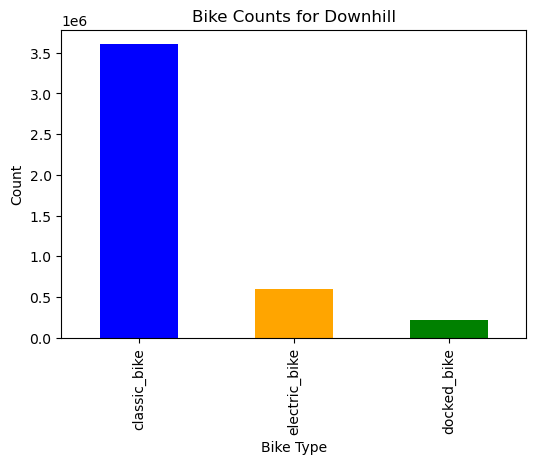

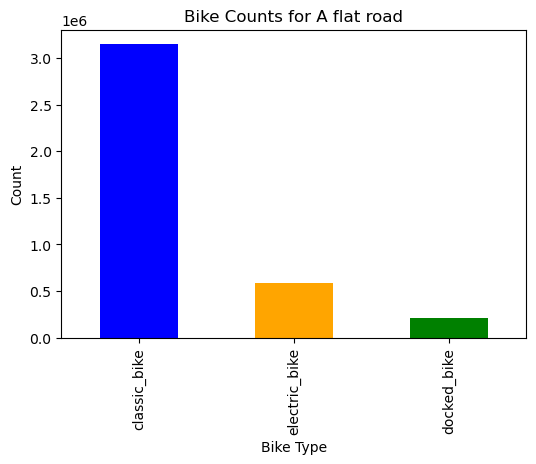

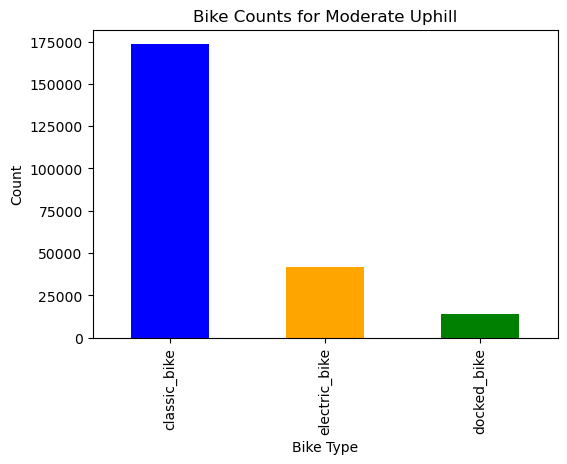

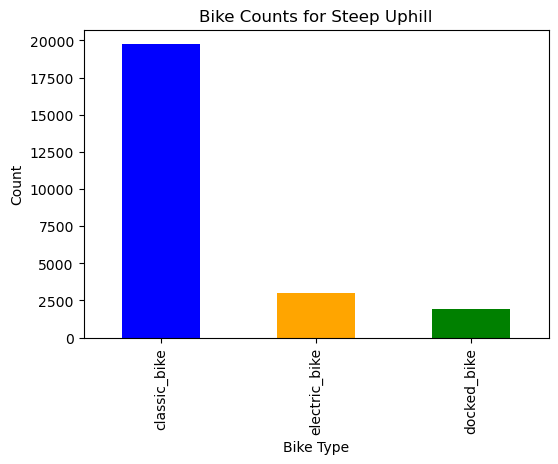

In [ ]:
for category in categories:
    # Select only the trips that belong to this road type
    df_cat = routes[routes['inclination_category'] == category]
    
    # Count how many bikes of each type were used
    counts = df_cat['rideable_type'].value_counts()
    
    # Create a bar plot
    plt.figure(figsize=(6, 4))  # Set the figure size
    counts.plot(kind='bar', color=['blue', 'orange', 'green'])  # Create a bar chart
    
    # Add titles and labels
    plt.title(f"Bike Counts for {category}")
    plt.xlabel("Bike Type")
    plt.ylabel("Count")
    
    # Show the plot
    plt.show()


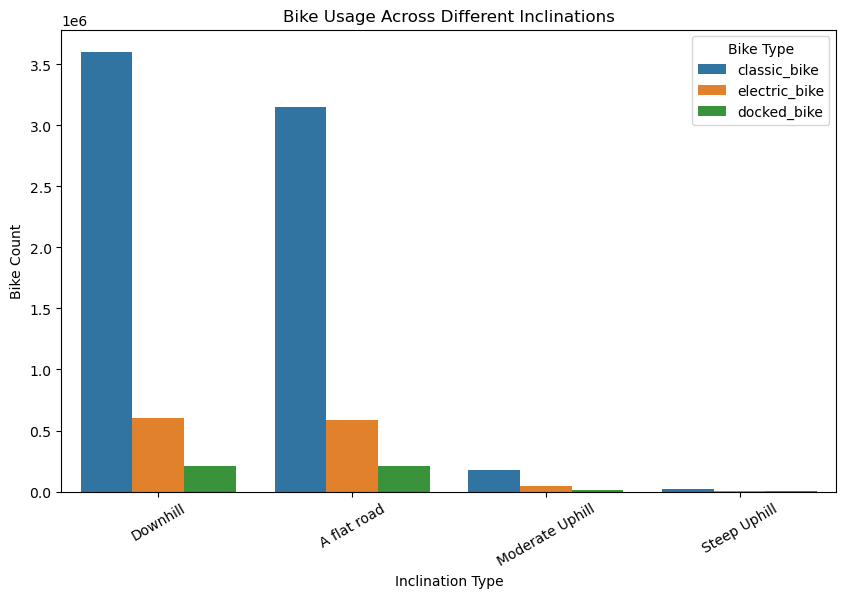

In [ ]:

# Create an empty DataFrame to store all counts
bike_counts = []

# Loop through each category and count the bikes
for category in categories:
    df_cat = routes[routes['inclination_category'] == category]
    counts = df_cat['rideable_type'].value_counts()
    
    # Store the data with the category name
    for bike_type, count in counts.items():
        bike_counts.append({"Inclination": category, "Bike Type": bike_type, "Count": count})

# Convert to DataFrame
bike_counts_df = pd.DataFrame(bike_counts)

# Plot using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(data=bike_counts_df, x="Inclination", y="Count", hue="Bike Type")

# Labels and title
plt.xticks(rotation=30)  # Rotate x-axis labels for readability
plt.xlabel("Inclination Type")
plt.ylabel("Bike Count")
plt.title("Bike Usage Across Different Inclinations")
# plt.ylim(0, 100000)
# Show the plot
plt.legend(title="Bike Type")
plt.show()


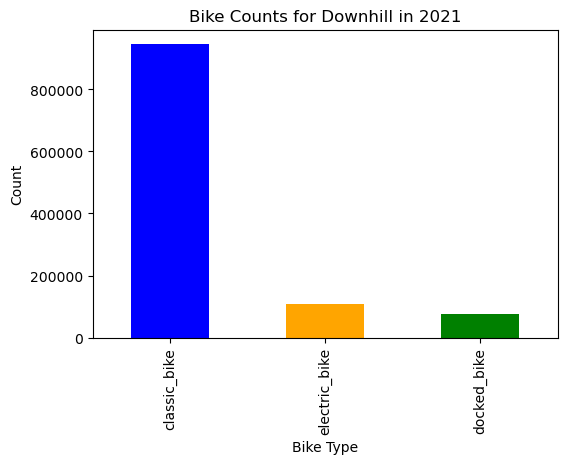

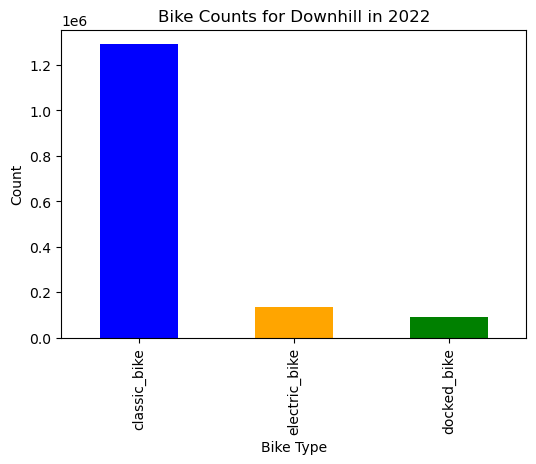

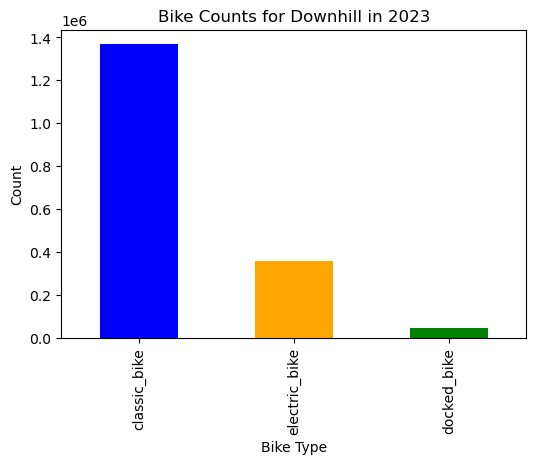

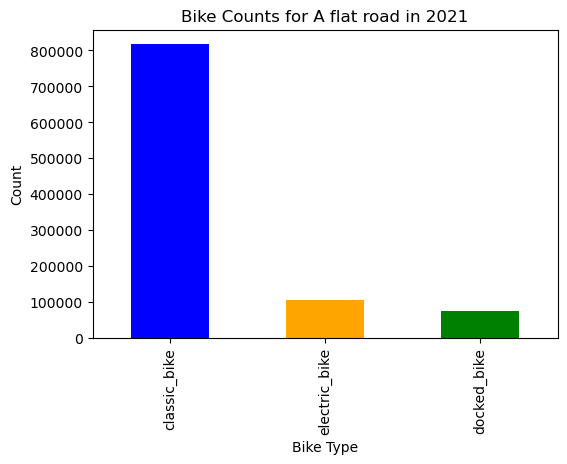

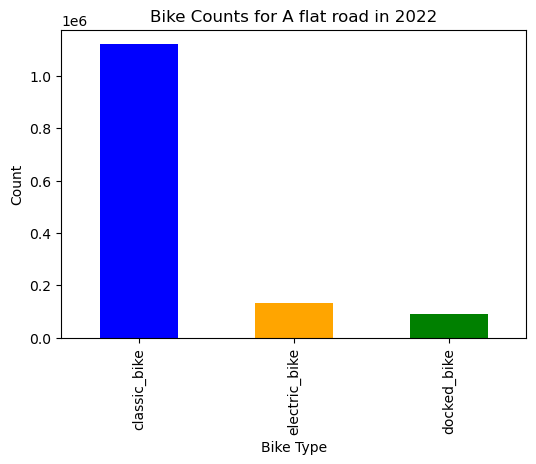

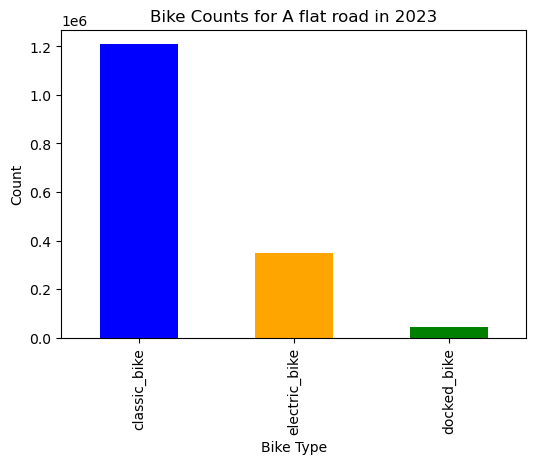

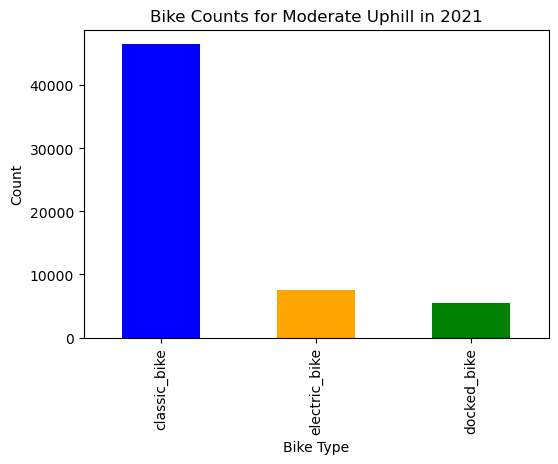

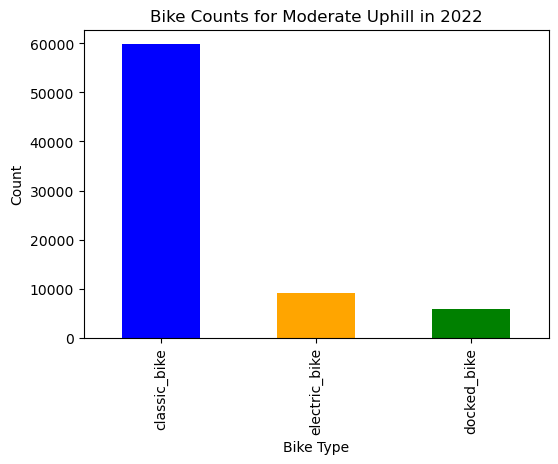

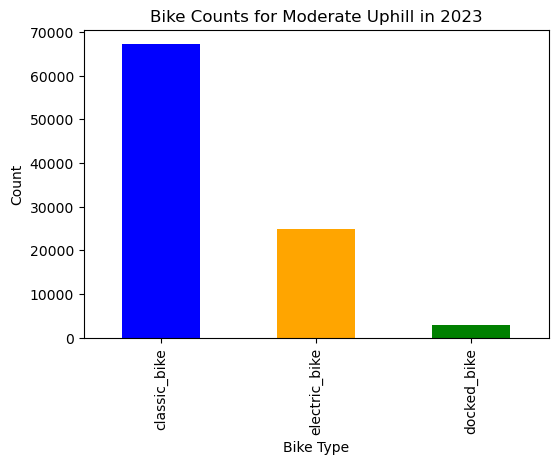

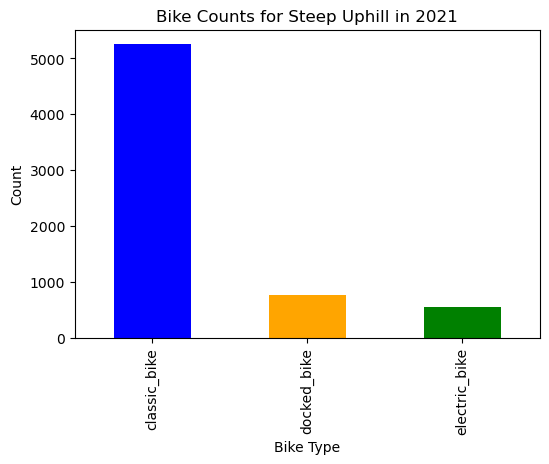

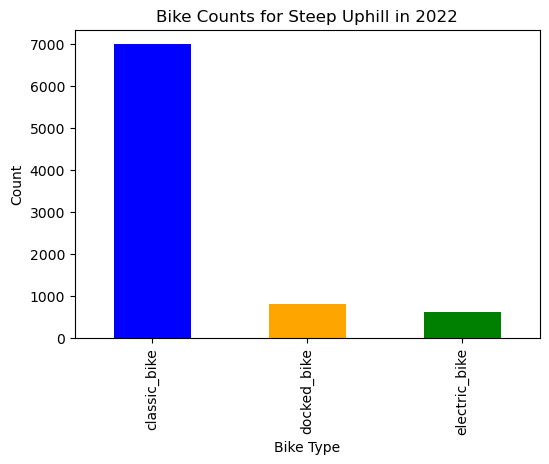

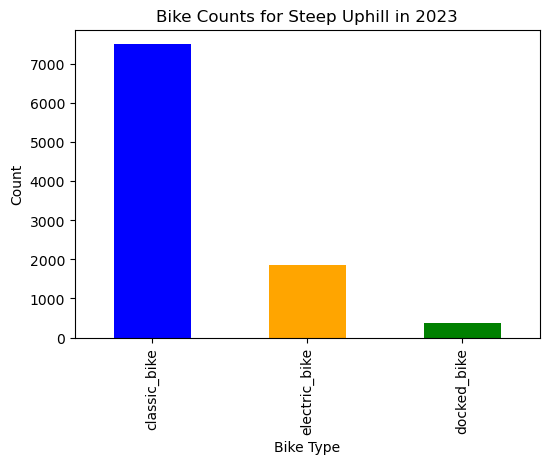

In [ ]:
# First, ensure that 'started_at' is a datetime column
routes['started_at'] = pd.to_datetime(routes['started_at'])

# Extract the year from the 'started_at' column
routes['year'] = routes['started_at'].dt.year

# Now loop through categories and years as before
for category in categories:
    for year in [2021, 2022, 2023]:  # Loop through each year
        # Select only the trips that belong to this road type and year
        df_cat_year = routes[(routes['inclination_category'] == category) & (routes['year'] == year)]
        
        # Count how many bikes of each type were used
        counts = df_cat_year['rideable_type'].value_counts()
        
        # Create a bar plot
        plt.figure(figsize=(6, 4))  # Set the figure size
        counts.plot(kind='bar', color=['blue', 'orange', 'green'])  # Create a bar chart
        
        # Add titles and labels
        plt.title(f"Bike Counts for {category} in {year}")
        plt.xlabel("Bike Type")
        plt.ylabel("Count")
        
        # Show the plot
        plt.show()


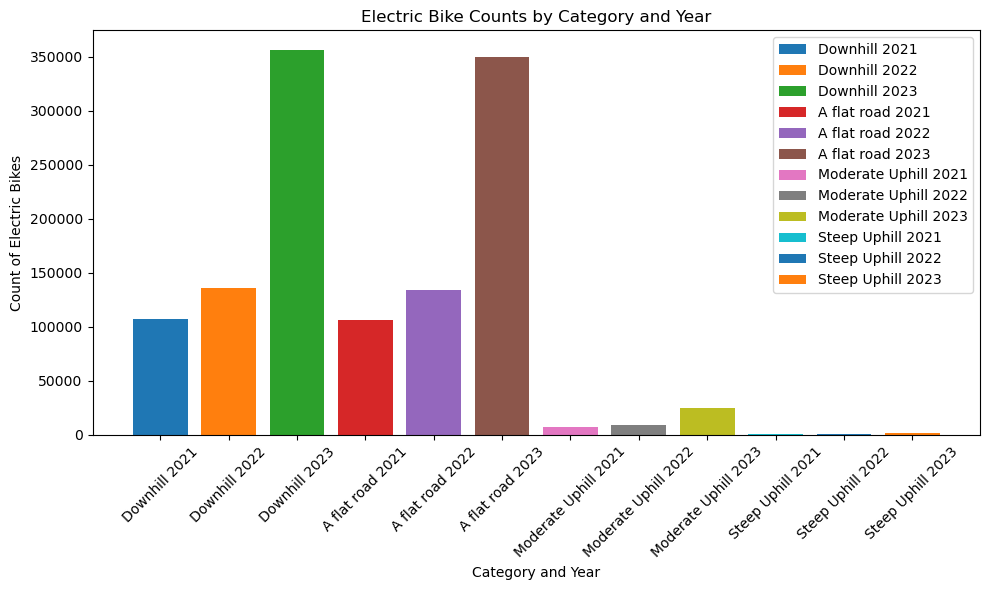

In [ ]:
# First, ensure that 'started_at' is a datetime column
routes['started_at'] = pd.to_datetime(routes['started_at'])

# Extract the year from the 'started_at' column
routes['year'] = routes['started_at'].dt.year

# Filter for electric bikes only
electric_bikes = routes[routes['rideable_type'] == 'electric_bike']

# Create a bar plot for each category and year
plt.figure(figsize=(10, 6))  # Set the figure size

# Loop through categories and years and plot on the same graph
for category in categories:
    for year in [2021, 2022, 2023]:
        # Select trips that belong to this road type, year, and are electric bikes
        df_cat_year = electric_bikes[(electric_bikes['inclination_category'] == category) & (electric_bikes['year'] == year)]
        
        # Count how many electric bikes were used
        counts = df_cat_year['rideable_type'].value_counts()
        
        # Plot the counts on the same graph
        plt.bar(f"{category} {year}", counts.get('electric_bike', 0), label=f"{category} {year}")

# Add titles and labels
plt.title("Electric Bike Counts by Category and Year")
plt.xlabel("Category and Year")
plt.ylabel("Count of Electric Bikes")

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)

# Show the legend
plt.legend()

# Show the plot
plt.tight_layout()  # Adjust layout for better fit
plt.show()


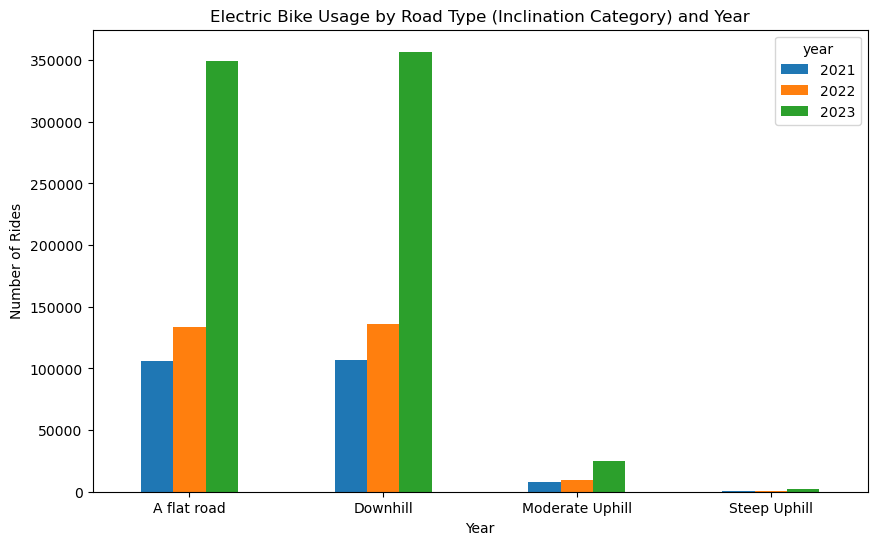

In [ ]:
# Ensure the 'started_at' column is a datetime type
routes['started_at'] = pd.to_datetime(routes['started_at'])

# Extract the year from the 'started_at' column
routes['year'] = routes['started_at'].dt.year

# Filter the data for electric bikes
e_bike_data = routes[routes['rideable_type'] == 'electric_bike']

# Group the data by 'inclination_category' and 'year' to count e-bike rides
e_bike_usage_by_inclination = e_bike_data.groupby(['inclination_category', 'year']).size().unstack(fill_value=0)

# Plot the results to compare e-bike usage by road type (inclination category) and year
e_bike_usage_by_inclination.plot(kind='bar', figsize=(10, 6))
plt.title('Electric Bike Usage by Road Type (Inclination Category) and Year')
plt.xlabel('Year')
plt.ylabel('Number of Rides')
plt.xticks(rotation=0)
plt.show()


In [ ]:
# Ensure the 'started_at' column is a datetime type
routes['started_at'] = pd.to_datetime(routes['started_at'])

# Extract the year from the 'started_at' column
routes['year'] = routes['started_at'].dt.year

# Filter the data for electric bikes
e_bike_data = routes[routes['rideable_type'] == 'electric_bike']

# Group the data by 'inclination_category' and 'year' to count e-bike rides
e_bike_usage_by_inclination = e_bike_data.groupby(['inclination_category', 'year']).size().unstack(fill_value=0)

# Display the raw numbers without a graph
print(e_bike_usage_by_inclination)


year                    2021    2022    2023
inclination_category                        
A flat road           105845  133940  349561
Downhill              107149  136072  356773
Moderate Uphill         7589    9137   24968
Steep Uphill             543     613    1852


In [ ]:
growth_2021_2023 = (e_bike_usage_by_inclination[2023] - e_bike_usage_by_inclination[2021]) / e_bike_usage_by_inclination[2021] * 100
print(growth_2021_2023)


inclination_category
A flat road        230.257452
Downhill           232.969043
Moderate Uphill    229.002504
Steep Uphill       241.068140
dtype: float64


In [ ]:
total_trips_per_year = e_bike_usage_by_inclination.sum(axis=0)
proportion_by_category = e_bike_usage_by_inclination.div(total_trips_per_year, axis=1)
print(proportion_by_category)


year                      2021      2022      2023
inclination_category                              
A flat road           0.478664  0.478764  0.476791
Downhill              0.484561  0.486385  0.486628
Moderate Uphill       0.034320  0.032660  0.034056
Steep Uphill          0.002456  0.002191  0.002526


In [ ]:
# Filter the data for electric bikes
classic_bike_data = routes[routes['rideable_type'] == 'classic_bike']

# Group the data by 'inclination_category' and 'year' to count e-bike rides
classic_bike_usage_by_inclination = classic_bike_data.groupby(['inclination_category', 'year']).size().unstack(fill_value=0)

# Display the raw numbers without a graph
print(classic_bike_usage_by_inclination)

year                    2021     2022     2023
inclination_category                          
A flat road           817348  1120754  1208636
Downhill              945430  1291649  1367735
Moderate Uphill        46479    59834    67154
Steep Uphill            5251     6993     7501


In [ ]:
growth_2021_2023_classic = (classic_bike_usage_by_inclination[2023] - classic_bike_usage_by_inclination[2021]) / classic_bike_usage_by_inclination[2021] * 100
print(growth_2021_2023_classic)

inclination_category
A flat road        47.872877
Downhill           44.668035
Moderate Uphill    44.482454
Steep Uphill       42.848981
dtype: float64


In [ ]:
total_trips_per_year_classic = classic_bike_usage_by_inclination.sum(axis=0)
proportion_by_category_classic = classic_bike_usage_by_inclination.div(total_trips_per_year_classic, axis=1)
print(proportion_by_category_classic)

year                      2021      2022      2023
inclination_category                              
A flat road           0.450452  0.452057  0.455913
Downhill              0.521039  0.520988  0.515927
Moderate Uphill       0.025615  0.024134  0.025331
Steep Uphill          0.002894  0.002821  0.002829


This shows that the Steep Uphill category has had the highest proportional growth from 2021 to 2023, followed by Downhill, A flat road, and Moderate Uphill.

<Figure size 1000x600 with 0 Axes>

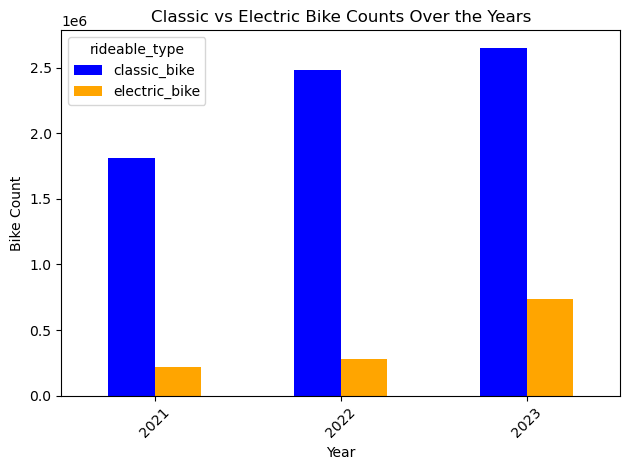

In [ ]:
# First, ensure that 'started_at' is a datetime column
routes['started_at'] = pd.to_datetime(routes['started_at'])

# Extract the year from the 'started_at' column
routes['year'] = routes['started_at'].dt.year

# Filter for both classic and electric bikes
bike_types = routes[routes['rideable_type'].isin(['classic_bike', 'electric_bike'])]

# Group by year and bike type, then count the number of occurrences
bike_counts_by_year = bike_types.groupby(['year', 'rideable_type']).size().unstack(fill_value=0)

# Plot the counts of classic and electric bikes over the years
plt.figure(figsize=(10, 6))  # Set the figure size

# Plotting the bar chart
bike_counts_by_year.plot(kind='bar', stacked=False, color=['blue', 'orange'])

# Add titles and labels
plt.title("Classic vs Electric Bike Counts Over the Years")
plt.xlabel("Year")
plt.ylabel("Bike Count")
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()  # Adjust layout for better fit
plt.show()


In [ ]:
routes

,rideable_type,started_at,ended_at,start_station_name,end_station_name,start_lat,start_lng,end_lat,end_lng,member_casual,...,was_dropped,start_elevation,end_elevation,elevation_change,start_elevation_label,end_elevation_label,distance_meters,inclination_percent,inclination_category,year
0,classic_bike,2021-01-01 00:08:33,2021-01-01 00:33:53,Maine Ave & 9th St SW,Rosslyn Metro / Wilson Blvd & Ft Myer Dr,38.880440,-77.025236,38.894600,-77.072305,member,...,False,3.0,51.0,48.0,low,medium,4367.592696,1.099004,A flat road,2021
2,electric_bike,2021-01-01 00:14:32,2021-01-01 00:28:45,17th & Corcoran St NW,14th & Belmont St NW,38.912138,-77.038568,38.920870,-77.031691,member,...,False,29.0,51.0,22.0,medium,medium,1138.842581,1.931786,A flat road,2021
4,classic_bike,2021-01-01 00:17:46,2021-01-01 00:21:00,11th & Park Rd NW,14th & Newton St NW,38.931322,-77.028247,38.931991,-77.032956,member,...,False,60.0,62.0,2.0,medium,medium,414.049529,0.483034,A flat road,2021
6,classic_bike,2021-01-01 00:19:06,2021-01-01 00:36:28,Bladensburg Rd & Benning Rd NE,Good Hope Rd & MLK Ave SE,38.900413,-76.982872,38.867373,-76.988039,casual,...,False,11.0,12.0,1.0,low,low,3701.002226,0.027020,A flat road,2021
8,docked_bike,2021-01-01 00:21:19,2021-01-01 00:33:31,15th & F St NE,1st & M St SE,38.897195,-76.983575,38.876893,-77.006072,casual,...,False,18.0,8.0,-10.0,low,low,2981.222620,-0.335433,Downhill,2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10693990,classic_bike,2023-12-31 23:57:53,2024-01-01 00:13:53,18th & New Hampshire Ave NW,17th & K St NW,38.911268,-77.041829,38.902760,-77.038630,member,...,False,33.0,34.0,1.0,medium,medium,985.709921,0.101450,A flat road,2023
10693991,classic_bike,2023-12-31 23:57:56,2024-01-01 00:02:25,Eastern Market Metro / Pennsylvania Ave & 8th ...,Lincoln Park / 13th & East Capitol St NE,38.884095,-76.995234,38.890461,-76.988355,casual,...,False,21.0,28.0,7.0,medium,medium,924.983952,0.756770,A flat road,2023
10693992,classic_bike,2023-12-31 23:58:06,2024-01-01 00:12:29,King St & Peyton St,Market Square / King St & Royal St,38.806002,-77.055911,38.804718,-77.043363,member,...,False,11.0,16.0,5.0,low,low,1096.641932,0.455937,A flat road,2023
10693993,electric_bike,2023-12-31 23:58:27,2024-01-01 00:02:28,Eastern Market Metro / Pennsylvania Ave & 8th ...,Lincoln Park / 13th & East Capitol St NE,38.884185,-76.995396,38.890461,-76.988355,member,...,False,21.0,28.0,7.0,medium,medium,926.459560,0.755565,A flat road,2023


In [ ]:
# First, ensure that 'started_at' is a datetime column
routes['started_at'] = pd.to_datetime(routes['started_at'])

# Extract the year from the 'started_at' column
routes['year'] = routes['started_at'].dt.year

# Filter for only classic and electric bikes
bike_types = ['classic_bike', 'electric_bike']
bike_data = routes[routes['rideable_type'].isin(bike_types)]

# Group by year and bike type, and count the occurrences
bike_counts = bike_data.groupby(['year', 'rideable_type']).size().unstack(fill_value=0)

# Calculate the percentage growth for each bike type (electric and classic)
growth = bike_counts.pct_change().multiply(100)  # Convert to percentage

growth

rideable_type,classic_bike,electric_bike
year,,
2021,NaN,NaN
2022,36.633732,26.517008
2023,6.929410,162.063468


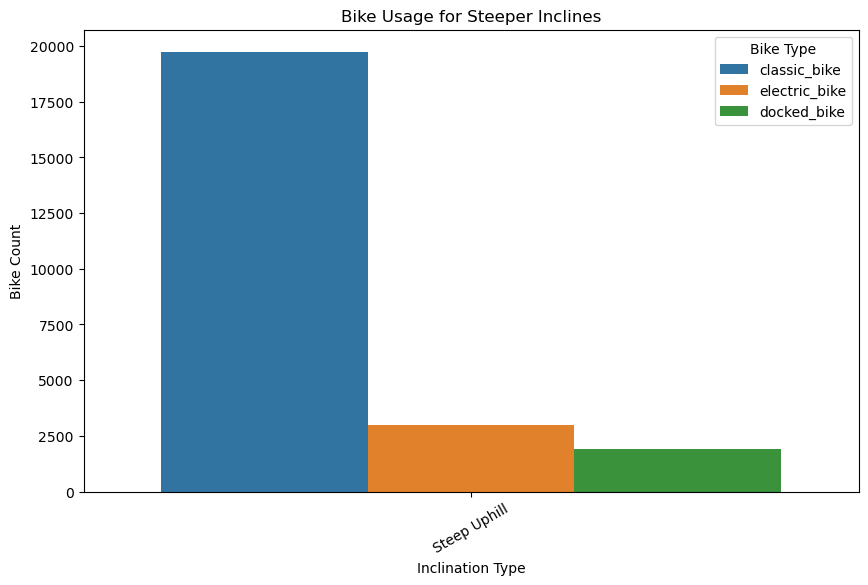

In [ ]:
# Define selected categories (from "Manageable gradient" and higher)
selected_categories = ["Steep Uphill"]

# Filter DataFrame
filtered_bike_counts_df = bike_counts_df[bike_counts_df["Inclination"].isin(selected_categories)]

# Plot using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(data=filtered_bike_counts_df, x="Inclination", y="Count", hue="Bike Type")

# Labels and title
plt.xticks(rotation=30)  # Rotate x-axis labels for readability
plt.xlabel("Inclination Type")
plt.ylabel("Bike Count")
plt.title("Bike Usage for Steeper Inclines")

# Set y-axis limit
# plt.ylim(0, 5000)  # Limit y-axis from 0 to 5000

# Show the plot
plt.legend(title="Bike Type")
plt.show()


In [ ]:
routes['rideable_type'].value_counts()

rideable_type
classic_bike     6944764
electric_bike    1234042
docked_bike       434281
Name: count, dtype: int64

([<matplotlib.patches.Wedge at 0x19f78bb5340>,
 [Text(-0.9025476443226041, 0.6288145590933135, 'Classic Bike'),
  Text(0.8640637452287457, -0.8327027345825602, 'Electric Bike'),
  Text(1.0862285697043035, -0.17351511276584353, 'Docked Bike')],
 [Text(-0.49229871508505674, 0.3429897595054437, '80.6%'),
  Text(0.5040371847167683, -0.4857432618398267, '14.3%'),
  Text(0.5924883107478018, -0.09464460696318737, '5.0%')])

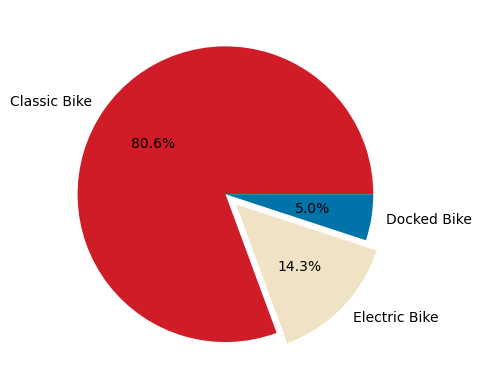

In [ ]:
ride = routes['rideable_type'].value_counts()
fig, ax = plt.subplots()
ax.pie(ride, explode = (0, 0.1, 0), labels= ['Classic Bike', 'Electric Bike', 'Docked Bike'], autopct='%1.1f%%',
       colors=['#D01C27', '#F0E2C4','#0074A8'])

In [ ]:
station_counts = routes.groupby('start_station_name')['rideable_type'].value_counts()

In [ ]:
station_counts

start_station_name          rideable_type
10th & E St NW              classic_bike     22507
                            docked_bike       3402
                            electric_bike     3177
10th & Florida Ave NW       classic_bike     15376
                            electric_bike     2376
                                             ...  
Woody Ward Rec Center       classic_bike        25
                            electric_bike       16
Yuma St & Tenley Circle NW  classic_bike      2378
                            electric_bike      435
                            docked_bike         65
Name: count, Length: 2500, dtype: int64

In [ ]:
# Convert to DataFrame
station_counts_df = station_counts.reset_index(name='count')

# Now you have a DataFrame where each row has start_station_name, rideable_type, and count
station_counts_df


,start_station_name,rideable_type,count
0,10th & E St NW,classic_bike,22507
1,10th & E St NW,docked_bike,3402
2,10th & E St NW,electric_bike,3177
3,10th & Florida Ave NW,classic_bike,15376
4,10th & Florida Ave NW,electric_bike,2376
...,...,...,...
2495,Woody Ward Rec Center,classic_bike,25
2496,Woody Ward Rec Center,electric_bike,16
2497,Yuma St & Tenley Circle NW,classic_bike,2378
2498,Yuma St & Tenley Circle NW,electric_bike,435


In [ ]:
# # Count the number of rides starting at each station
# start_counts = full_df['start_station_name'].value_counts()

# # Count the number of rides ending at each station
# end_counts = full_df['end_station_name'].value_counts()

# # Merge the counts to calculate total demand for each station
# station_demand = pd.DataFrame({
#     'starts': start_counts,
#     'ends': end_counts
# }).fillna(0)  # Fill NaN values with 0, as some stations may not appear in both

# # Calculate total demand
# station_demand['net_demand'] = station_demand['starts'] - station_demand['ends']

# # Sort by demand to find stations with the highest demand
# station_demand = station_demand.sort_values(by='net_demand', ascending=False)

# # Display the top stations with the highest demand
# station_demand

In [ ]:
# Count the number of rides starting at each station by bike type
start_counts = full_df.groupby(['start_station_name', 'rideable_type']).size()

# Count the number of rides ending at each station by bike type
end_counts = full_df.groupby(['end_station_name', 'rideable_type']).size()

# Merge the counts on both station name and rideable_type, filling missing values with 0
station_demand = pd.DataFrame({
    'starts': start_counts,
    'ends': end_counts
}).fillna(0)  # Fill NaN values with 0 for stations/bike types with no starts or ends

# Calculate net demand (starts - ends) for each station and bike type
station_demand['net_demand'] = station_demand['starts'] - station_demand['ends']

# Sort by net demand to find stations with the highest demand
station_demand = station_demand.sort_values(by='net_demand', ascending=False)

# Reset the index to make 'rideable_type' a column
station_demand = station_demand.reset_index()

# Rename the column in case 'level_0' appears
station_demand = station_demand.rename(columns={'level_0': 'start_station_name'})

# Now you can filter for 'electric_bike' in the 'rideable_type' column
station_demand_electric = station_demand[station_demand['rideable_type'] == 'electric_bike']

# Display the results for 'electric_bike'
station_demand_electric


,start_station_name,rideable_type,starts,ends,net_demand
85,11th & Kenyon St NW,electric_bike,8695.0,7397.0,1298.0
100,Park Rd & Holmead Pl NW,electric_bike,7613.0,6641.0,972.0
111,Columbia Rd & Georgia Ave NW,electric_bike,6847.0,6039.0,808.0
121,Kansas Ave & Sherman Cr NW,electric_bike,4652.0,3941.0,711.0
150,14th & Otis Pl NW,electric_bike,6354.0,5854.0,500.0
...,...,...,...,...,...
2339,Adams Mill & Columbia Rd NW,electric_bike,11680.0,12076.0,-396.0
2340,14th & R St NW,electric_bike,8994.0,9401.0,-407.0
2345,Columbia & Ontario Rd NW,electric_bike,9181.0,9604.0,-423.0
2364,16th & Irving St NW,electric_bike,5175.0,5696.0,-521.0


In [ ]:
# Now you can filter for 'electric_bike' in the 'rideable_type' column
station_demand_classic = station_demand[station_demand['rideable_type'] == 'classic_bike']

# Display the results for 'electric_bike'
station_demand_classic

,start_station_name,rideable_type,starts,ends,net_demand
0,11th & Kenyon St NW,classic_bike,29237.0,16821.0,12416.0
1,Park Rd & Holmead Pl NW,classic_bike,25451.0,14173.0,11278.0
2,Columbia & Ontario Rd NW,classic_bike,30654.0,20779.0,9875.0
3,14th & Irving St NW,classic_bike,35638.0,26102.0,9536.0
4,14th & Otis Pl NW,classic_bike,19808.0,11072.0,8736.0
...,...,...,...,...,...
2521,Metro Center / 12th & G St NW,classic_bike,30329.0,37827.0,-7498.0
2522,23rd & M St NW,classic_bike,38517.0,46784.0,-8267.0
2523,Georgetown Harbor / 30th St NW,classic_bike,22944.0,31583.0,-8639.0
2524,Thomas Jefferson St NW & Water/K St NW,classic_bike,13486.0,22274.0,-8788.0


In [ ]:
# # Vectorized condition for Supply_Status
# station_demand['Supply_Status'] = np.where(station_demand['net_demand'] < -5, 'Oversupplied',
#                                            np.where(station_demand['net_demand'] > 5, 'Undersupplied', 'Perfect'))

# # Display the updated DataFrame
# station_demand[['net_demand', 'Supply_Status']]


In [ ]:
# Vectorized condition for Supply_Status
station_demand_electric['Supply_Status'] = np.where(station_demand_electric['net_demand'] < -5, 'Oversupplied',
                                           np.where(station_demand_electric['net_demand'] > 5, 'Undersupplied', 'Perfect'))

# Display the updated DataFrame
station_demand_electric[['net_demand', 'Supply_Status']]


D:\Users\Olunia\AppData\Local\Temp\ipykernel_15328\3455968114.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station_demand_electric['Supply_Status'] = np.where(station_demand_electric['net_demand'] < -5, 'Oversupplied',


,net_demand,Supply_Status
85,1298.0,Undersupplied
100,972.0,Undersupplied
111,808.0,Undersupplied
121,711.0,Undersupplied
150,500.0,Undersupplied
...,...,...
2339,-396.0,Oversupplied
2340,-407.0,Oversupplied
2345,-423.0,Oversupplied
2364,-521.0,Oversupplied


In [ ]:
station_demand_electric

,start_station_name,rideable_type,starts,ends,net_demand,Supply_Status
85,11th & Kenyon St NW,electric_bike,8695.0,7397.0,1298.0,Undersupplied
100,Park Rd & Holmead Pl NW,electric_bike,7613.0,6641.0,972.0,Undersupplied
111,Columbia Rd & Georgia Ave NW,electric_bike,6847.0,6039.0,808.0,Undersupplied
121,Kansas Ave & Sherman Cr NW,electric_bike,4652.0,3941.0,711.0,Undersupplied
150,14th & Otis Pl NW,electric_bike,6354.0,5854.0,500.0,Undersupplied
...,...,...,...,...,...,...
2339,Adams Mill & Columbia Rd NW,electric_bike,11680.0,12076.0,-396.0,Oversupplied
2340,14th & R St NW,electric_bike,8994.0,9401.0,-407.0,Oversupplied
2345,Columbia & Ontario Rd NW,electric_bike,9181.0,9604.0,-423.0,Oversupplied
2364,16th & Irving St NW,electric_bike,5175.0,5696.0,-521.0,Oversupplied


In [ ]:
# Vectorized condition for Supply_Status
station_demand_classic['Supply_Status'] = np.where(station_demand_classic['net_demand'] < -5, 'Oversupplied',
                                           np.where(station_demand_classic['net_demand'] > 5, 'Undersupplied', 'Perfect'))

# Display the updated DataFrame
station_demand_classic[['net_demand', 'Supply_Status']]

D:\Users\Olunia\AppData\Local\Temp\ipykernel_15328\1760015815.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station_demand_classic['Supply_Status'] = np.where(station_demand_classic['net_demand'] < -5, 'Oversupplied',


,net_demand,Supply_Status
0,12416.0,Undersupplied
1,11278.0,Undersupplied
2,9875.0,Undersupplied
3,9536.0,Undersupplied
4,8736.0,Undersupplied
...,...,...
2521,-7498.0,Oversupplied
2522,-8267.0,Oversupplied
2523,-8639.0,Oversupplied
2524,-8788.0,Oversupplied


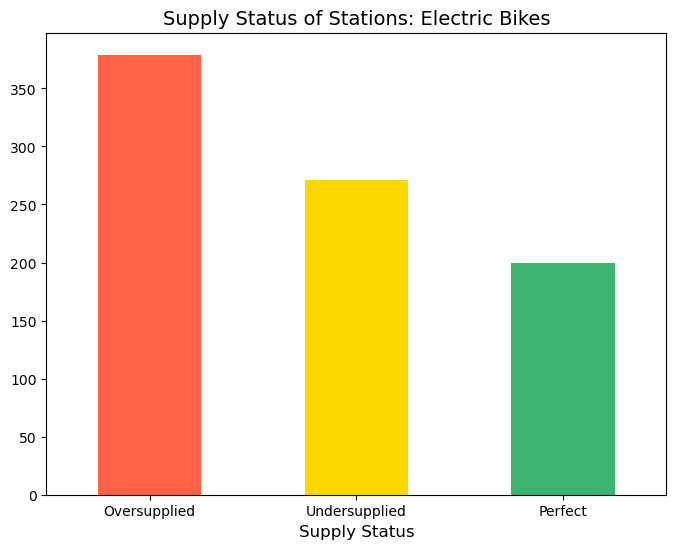

In [ ]:
# Plotting the count of each supply status
supply_counts_electric = station_demand_electric['Supply_Status'].value_counts()

plt.figure(figsize=(8, 6))
supply_counts_electric.plot(kind='bar', color=['#FF6347', '#FFD700', '#3CB371'])

# Adding labels and title
plt.title('Supply Status of Stations: Electric Bikes', fontsize=14)
plt.xlabel('Supply Status', fontsize=12)
# plt.ylabel('Count of Stations', fontsize=12)

# Show plot
plt.xticks(rotation=0)
plt.show()


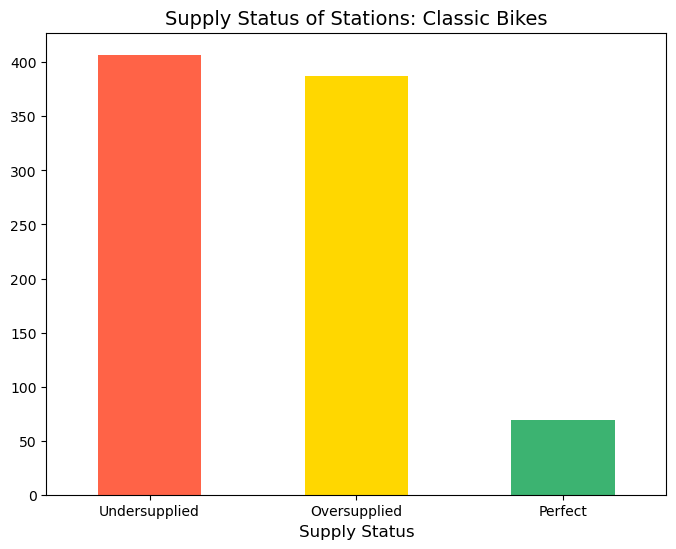

In [ ]:
# Plotting the count of each supply status
supply_counts_classic = station_demand_classic['Supply_Status'].value_counts()

plt.figure(figsize=(8, 6))
supply_counts_classic.plot(kind='bar', color=['#FF6347', '#FFD700', '#3CB371'])

# Adding labels and title
plt.title('Supply Status of Stations: Classic Bikes', fontsize=14)
plt.xlabel('Supply Status', fontsize=12)
# plt.ylabel('Count of Stations', fontsize=12)

# Show plot
plt.xticks(rotation=0)
plt.show()

In [ ]:
# Merge routes with station demand data for both classic and electric bikes
merged_electric = routes[routes['rideable_type'] == 'electric_bike'].merge(
    station_demand_electric[['start_station_name', 'net_demand', 'Supply_Status']], 
    left_on='start_station_name', right_on='start_station_name', how='left'
)

merged_classic = routes[routes['rideable_type'] == 'classic_bike'].merge(
    station_demand_classic[['start_station_name', 'net_demand', 'Supply_Status']], 
    left_on='start_station_name', right_on='start_station_name', how='left'
)

# Now calculate demand for each year and bike type
demand_by_year_electric = merged_electric.groupby(['year', 'rideable_type']).size().unstack(fill_value=0)
demand_by_year_classic = merged_classic.groupby(['year', 'rideable_type']).size().unstack(fill_value=0)

# Optionally, compare if stations are oversupplied or undersupplied by checking the 'Supply_Status'
# Example: Check for oversupply or undersupply based on 'net_demand'
stations_oversupplied_electric = station_demand_electric[station_demand_electric['net_demand'] < -5]
stations_perfect_electric = station_demand_electric[station_demand_electric['net_demand'].between(-5, 5)]
stations_undersupplied_electric = station_demand_electric[station_demand_electric['net_demand'] > 5]

stations_oversupplied_classic = station_demand_classic[station_demand_classic['net_demand'] < -5]
stations_perfect_classic= station_demand_classic[station_demand_classic['net_demand'].between(-5, 5)]
stations_undersupplied_classic = station_demand_classic[station_demand_classic['net_demand'] > 5]

demand_by_year_electric


rideable_type,electric_bike
year,
2021,221126
2022,279762
2023,733154


In [ ]:
station_demand_classic

,start_station_name,rideable_type,starts,ends,net_demand,Supply_Status
0,11th & Kenyon St NW,classic_bike,29237.0,16821.0,12416.0,Undersupplied
1,Park Rd & Holmead Pl NW,classic_bike,25451.0,14173.0,11278.0,Undersupplied
2,Columbia & Ontario Rd NW,classic_bike,30654.0,20779.0,9875.0,Undersupplied
3,14th & Irving St NW,classic_bike,35638.0,26102.0,9536.0,Undersupplied
4,14th & Otis Pl NW,classic_bike,19808.0,11072.0,8736.0,Undersupplied
...,...,...,...,...,...,...
2521,Metro Center / 12th & G St NW,classic_bike,30329.0,37827.0,-7498.0,Oversupplied
2522,23rd & M St NW,classic_bike,38517.0,46784.0,-8267.0,Oversupplied
2523,Georgetown Harbor / 30th St NW,classic_bike,22944.0,31583.0,-8639.0,Oversupplied
2524,Thomas Jefferson St NW & Water/K St NW,classic_bike,13486.0,22274.0,-8788.0,Oversupplied


In [ ]:
routes

MemoryError: Unable to allocate 65.7 MiB for an array with shape (1, 8613087) and data type datetime64[ns]

MemoryError: Unable to allocate 65.7 MiB for an array with shape (1, 8613087) and data type object

In [ ]:
from folium.plugins import HeatMap
merged_station_demand_electric = pd.merge(
    station_demand_electric[['start_station_name', 'Supply_Status']],
    full_df[['start_station_name', 'start_lat', 'start_lng']],
    on='start_station_name', how='left'
)

merged_station_demand_classic = pd.merge(
    station_demand_classic[['start_station_name', 'Supply_Status']],
    full_df[['start_station_name', 'start_lat', 'start_lng']],
    on='start_station_name', how='left'
)
# Filter the stations for oversupplied and undersupplied bikes
oversupplied_stations = merged_station_demand_electric[merged_station_demand_electric['Supply_Status'] == 'Oversupplied']
undersupplied_stations = merged_station_demand_electric[merged_station_demand_electric['Supply_Status'] == 'Undersupplied']

# Create a map centered at Washington DC
map_dc = folium.Map(location=[38.89511, -77.03637], zoom_start=12)

# Convert the oversupplied and undersupplied stations into a list of latitude and longitude pairs
oversupplied_data = [[row['start_lat'], row['start_lng']] for index, row in oversupplied_stations.iterrows()]
undersupplied_data = [[row['start_lat'], row['start_lng']] for index, row in undersupplied_stations.iterrows()]

# Add the heatmap layer for oversupplied stations
HeatMap(oversupplied_data, radius=15, blur=10, max_zoom=13).add_to(map_dc)

# Add the heatmap layer for undersupplied stations
HeatMap(undersupplied_data, radius=15, blur=10, max_zoom=13).add_to(map_dc)

# Display the map
map_dc



MemoryError: Unable to allocate 138. MiB for an array with shape (2, 9031213) and data type object

In [ ]:
# # Ensure 'started_at' is in datetime format
# full_df['started_at'] = pd.to_datetime(full_df['started_at'])

# # Extract the year from 'started_at' and create a new column 'year'
# full_df['year'] = full_df['started_at'].dt.year

# # Merge full_df with station demand data for both classic and electric bikes
# merged_electric = full_df[full_df['rideable_type'] == 'electric_bike'].merge(
#     station_demand_electric[['start_station_name', 'net_demand', 'Supply_Status']], 
#     left_on='start_station_name', right_on='start_station_name', how='left'
# )

# merged_classic = full_df[full_df['rideable_type'] == 'classic_bike'].merge(
#     station_demand_classic[['start_station_name', 'net_demand', 'Supply_Status']], 
#     left_on='start_station_name', right_on='start_station_name', how='left'
# )

# # Now calculate demand for each year and bike type
# demand_by_year_electric = merged_electric.groupby(['year', 'rideable_type']).size().unstack(fill_value=0)
# demand_by_year_classic = merged_classic.groupby(['year', 'rideable_type']).size().unstack(fill_value=0)

# # Optionally, compare if stations are oversupplied or undersupplied by checking the 'Supply_Status'
# stations_oversupplied_electric = station_demand_electric[station_demand_electric['net_demand'] < -5]
# stations_perfect_electric = station_demand_electric[station_demand_electric['net_demand'].between(-5, 5)]
# stations_undersupplied_electric = station_demand_electric[station_demand_electric['net_demand'] > 5]

# stations_oversupplied_classic = station_demand_classic[station_demand_classic['net_demand'] < -5]
# stations_perfect_classic = station_demand_classic[station_demand_classic['net_demand'].between(-5, 5)]
# stations_undersupplied_classic = station_demand_classic[station_demand_classic['net_demand'] > 5]

# demand_by_year_electric


In [ ]:
demand_by_year_classic

rideable_type,classic_bike
year,
2021,1814508
2022,2479230
2023,2651026


In [ ]:
merged_routes_electric = routes[routes['rideable_type'] == 'electric_bike'].merge(
    station_demand_electric[['start_station_name', 'net_demand', 'Supply_Status']], 
    on='start_station_name', 
    how='left'
)

In [ ]:
supply_status_by_year = merged_routes_electric.groupby(['year', 'Supply_Status']).size().unstack(fill_value=0)
print(supply_status_by_year)


Supply_Status  Oversupplied  Perfect  Undersupplied
year                                               
2021                 108611    12940          99575
2022                 138433    15789         125540
2023                 367871    40304         324979


In [ ]:
supply_status_growth = supply_status_by_year.pct_change().multiply(100)
print(supply_status_growth)


Supply_Status  Oversupplied     Perfect  Undersupplied
year                                                  
2021                    NaN         NaN            NaN
2022              27.457624   22.017002      26.075822
2023             165.739383  155.266325     158.864904


In [ ]:
merged_routes_classic = routes[routes['rideable_type'] == 'classic_bike'].merge(
    station_demand_classic[['start_station_name', 'net_demand', 'Supply_Status']], 
    on='start_station_name', 
    how='left'
)

supply_status_by_year_classic = merged_routes_classic.groupby(['year', 'Supply_Status']).size().unstack(fill_value=0)
supply_status_growth_classic = supply_status_by_year_classic.pct_change().multiply(100)

print(supply_status_by_year_classic)
print(supply_status_growth_classic)


Supply_Status  Oversupplied  Perfect  Undersupplied
year                                               
2021                1002517     5289         806702
2022                1407649     5788        1065793
2023                1517050     6665        1127311
Supply_Status  Oversupplied    Perfect  Undersupplied
year                                                 
2021                    NaN        NaN            NaN
2022              40.411484   9.434676      32.117312
2023               7.771895  15.152039       5.772040


In [ ]:
trips_per_year = routes.groupby('year').size()
print(trips_per_year)

year
2021    2193322
2022    2944324
2023    3475441
dtype: int64


In [ ]:
supply_status_normalized = supply_status_by_year.div(supply_status_by_year.sum(axis=1), axis=0)
print(supply_status_normalized)


Supply_Status  Oversupplied   Perfect  Undersupplied
year                                                
2021               0.491172  0.058519       0.450309
2022               0.494824  0.056437       0.448739
2023               0.501765  0.054973       0.443262


In [ ]:
station_counts_df.head()


,start_station_name,rideable_type,count
0,10th & E St NW,classic_bike,22507
1,10th & E St NW,docked_bike,3402
2,10th & E St NW,electric_bike,3177
3,10th & Florida Ave NW,classic_bike,15376
4,10th & Florida Ave NW,electric_bike,2376


In [ ]:
# Rename the 'index' column to 'start_station_name'
elevation= elevation.reset_index().rename(columns={'station_name': 'start_station_name'})

In [ ]:
station_demand_electric

,start_station_name,rideable_type,starts,ends,net_demand,Supply_Status
85,11th & Kenyon St NW,electric_bike,8695.0,7397.0,1298.0,Undersupplied
100,Park Rd & Holmead Pl NW,electric_bike,7613.0,6641.0,972.0,Undersupplied
111,Columbia Rd & Georgia Ave NW,electric_bike,6847.0,6039.0,808.0,Undersupplied
121,Kansas Ave & Sherman Cr NW,electric_bike,4652.0,3941.0,711.0,Undersupplied
150,14th & Otis Pl NW,electric_bike,6354.0,5854.0,500.0,Undersupplied
...,...,...,...,...,...,...
2339,Adams Mill & Columbia Rd NW,electric_bike,11680.0,12076.0,-396.0,Oversupplied
2340,14th & R St NW,electric_bike,8994.0,9401.0,-407.0,Oversupplied
2345,Columbia & Ontario Rd NW,electric_bike,9181.0,9604.0,-423.0,Oversupplied
2364,16th & Irving St NW,electric_bike,5175.0,5696.0,-521.0,Oversupplied


In [ ]:
# Merge the station_counts_df with supply status from station_demand
electric_bikes_elevation = pd.merge(elevation[['start_station_name','elevation']], station_demand_electric[['start_station_name', 'Supply_Status','net_demand']], on='start_station_name')
electric_bikes_elevation

,start_station_name,elevation,Supply_Status,net_demand
0,Maine Ave & 9th St SW,3.0,Oversupplied,-11.0
1,10th & U St NW,31.0,Oversupplied,-183.0
2,17th & Corcoran St NW,29.0,Oversupplied,-155.0
3,Wilson Blvd. & N. Vermont St.,82.0,Oversupplied,-10.0
4,11th & Park Rd NW,60.0,Undersupplied,183.0
...,...,...,...,...
844,Massachusetts & Idaho Ave NW,103.0,Perfect,-2.0
845,Dorr Ave & Prosperity Ave,106.0,Perfect,-1.0
846,Tyco Rd & Boyd Pointe Way,119.0,Perfect,0.0
847,Old Meadow Rd & Cathy Ln,121.0,Perfect,2.0


In [ ]:
# Encoding Supply_Status to numerical values
supply_status_mapping = {
    'Undersupplied': -1,
    'Perfect': 0,
    'Oversupplied': 1
}

electric_bikes_elevation['Supply_Status_Encoded'] = electric_bikes_elevation['Supply_Status'].map(supply_status_mapping)


In [ ]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Box plot to visualize the relationship between Supply_Status and Elevation
# plt.figure(figsize=(10, 6))
# sns.boxplot(data=electric_bikes_elevation, x='Supply_Status', y='elevation')

# # Add title and labels
# plt.title('Distribution of Electric Bikes by Supply Status Depending on elevation')
# plt.xlabel('Supply Status')
# # plt.ylabel('Elevation (m)')

# # Show the plot
# plt.show()


In [ ]:
# # Group by Supply_Status and calculate summary statistics for elevation
# elevation_summary = electric_bikes_elevation.groupby('Supply_Status')['elevation'].describe()

# # Show the summary statistics
# print(elevation_summary)


In [ ]:
classic_bikes_df = full_df[full_df['rideable_type'] == 'classic_bike']
classic_bikes_df

,rideable_type,started_at,ended_at,start_station_name,end_station_name,start_lat,start_lng,end_lat,end_lng,member_casual,trip_duration_minutes,was_dropped,start_elevation,end_elevation,elevation_change,start_elevation_label,end_elevation_label,distance_meters
0,classic_bike,2021-01-01 00:08:33,2021-01-01 00:33:53,Maine Ave & 9th St SW,Rosslyn Metro / Wilson Blvd & Ft Myer Dr,38.880440,-77.025236,38.894600,-77.072305,member,25.333333,False,3.0,51.0,-48.0,low,medium,4367.592696
3,classic_bike,2021-01-01 00:15:45,2021-01-01 00:21:20,Wilson Blvd. & N. Vermont St.,Wilson Blvd. & N. Vermont St.,38.879477,-77.114563,38.879477,-77.114563,member,5.583333,False,82.0,82.0,0.0,high,high,0.000000
4,classic_bike,2021-01-01 00:17:46,2021-01-01 00:21:00,11th & Park Rd NW,14th & Newton St NW,38.931322,-77.028247,38.931991,-77.032956,member,3.233333,False,60.0,62.0,-2.0,medium,medium,414.049529
6,classic_bike,2021-01-01 00:19:06,2021-01-01 00:36:28,Bladensburg Rd & Benning Rd NE,Good Hope Rd & MLK Ave SE,38.900413,-76.982872,38.867373,-76.988039,casual,17.366667,False,11.0,12.0,-1.0,low,low,3701.002226
9,classic_bike,2021-01-01 00:21:39,2021-01-01 00:31:07,14th & Otis Pl NW,14th & R St NW,38.934405,-77.032687,38.913046,-77.032008,member,9.466667,False,63.0,38.0,25.0,medium,medium,2375.738690
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10693990,classic_bike,2023-12-31 23:57:53,2024-01-01 00:13:53,18th & New Hampshire Ave NW,17th & K St NW,38.911268,-77.041829,38.902760,-77.038630,member,16.000000,False,33.0,34.0,-1.0,medium,medium,985.709921
10693991,classic_bike,2023-12-31 23:57:56,2024-01-01 00:02:25,Eastern Market Metro / Pennsylvania Ave & 8th ...,Lincoln Park / 13th & East Capitol St NE,38.884095,-76.995234,38.890461,-76.988355,casual,4.483333,False,21.0,28.0,-7.0,medium,medium,924.983952
10693992,classic_bike,2023-12-31 23:58:06,2024-01-01 00:12:29,King St & Peyton St,Market Square / King St & Royal St,38.806002,-77.055911,38.804718,-77.043363,member,14.383333,False,11.0,16.0,-5.0,low,low,1096.641932
10693994,classic_bike,2023-12-31 23:59:27,2024-01-01 02:09:11,22nd & P ST NW,23rd & E St NW,38.909394,-77.048728,38.896104,-77.049882,casual,129.733333,False,20.0,23.0,-3.0,medium,medium,1481.150682


In [ ]:
classic_bikes_df

,rideable_type,started_at,ended_at,start_station_name,end_station_name,start_lat,start_lng,end_lat,end_lng,member_casual,trip_duration_minutes,was_dropped,start_elevation,end_elevation,elevation_change,start_elevation_label,end_elevation_label,distance_meters
0,classic_bike,2021-01-01 00:08:33,2021-01-01 00:33:53,Maine Ave & 9th St SW,Rosslyn Metro / Wilson Blvd & Ft Myer Dr,38.880440,-77.025236,38.894600,-77.072305,member,25.333333,False,3.0,51.0,-48.0,low,medium,4367.592696
3,classic_bike,2021-01-01 00:15:45,2021-01-01 00:21:20,Wilson Blvd. & N. Vermont St.,Wilson Blvd. & N. Vermont St.,38.879477,-77.114563,38.879477,-77.114563,member,5.583333,False,82.0,82.0,0.0,high,high,0.000000
4,classic_bike,2021-01-01 00:17:46,2021-01-01 00:21:00,11th & Park Rd NW,14th & Newton St NW,38.931322,-77.028247,38.931991,-77.032956,member,3.233333,False,60.0,62.0,-2.0,medium,medium,414.049529
6,classic_bike,2021-01-01 00:19:06,2021-01-01 00:36:28,Bladensburg Rd & Benning Rd NE,Good Hope Rd & MLK Ave SE,38.900413,-76.982872,38.867373,-76.988039,casual,17.366667,False,11.0,12.0,-1.0,low,low,3701.002226
9,classic_bike,2021-01-01 00:21:39,2021-01-01 00:31:07,14th & Otis Pl NW,14th & R St NW,38.934405,-77.032687,38.913046,-77.032008,member,9.466667,False,63.0,38.0,25.0,medium,medium,2375.738690
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10693990,classic_bike,2023-12-31 23:57:53,2024-01-01 00:13:53,18th & New Hampshire Ave NW,17th & K St NW,38.911268,-77.041829,38.902760,-77.038630,member,16.000000,False,33.0,34.0,-1.0,medium,medium,985.709921
10693991,classic_bike,2023-12-31 23:57:56,2024-01-01 00:02:25,Eastern Market Metro / Pennsylvania Ave & 8th ...,Lincoln Park / 13th & East Capitol St NE,38.884095,-76.995234,38.890461,-76.988355,casual,4.483333,False,21.0,28.0,-7.0,medium,medium,924.983952
10693992,classic_bike,2023-12-31 23:58:06,2024-01-01 00:12:29,King St & Peyton St,Market Square / King St & Royal St,38.806002,-77.055911,38.804718,-77.043363,member,14.383333,False,11.0,16.0,-5.0,low,low,1096.641932
10693994,classic_bike,2023-12-31 23:59:27,2024-01-01 02:09:11,22nd & P ST NW,23rd & E St NW,38.909394,-77.048728,38.896104,-77.049882,casual,129.733333,False,20.0,23.0,-3.0,medium,medium,1481.150682


In [ ]:
station_demand_classic

,start_station_name,rideable_type,starts,ends,net_demand,Supply_Status
0,11th & Kenyon St NW,classic_bike,29237.0,16821.0,12416.0,Undersupplied
1,Park Rd & Holmead Pl NW,classic_bike,25451.0,14173.0,11278.0,Undersupplied
2,Columbia & Ontario Rd NW,classic_bike,30654.0,20779.0,9875.0,Undersupplied
3,14th & Irving St NW,classic_bike,35638.0,26102.0,9536.0,Undersupplied
4,14th & Otis Pl NW,classic_bike,19808.0,11072.0,8736.0,Undersupplied
...,...,...,...,...,...,...
2521,Metro Center / 12th & G St NW,classic_bike,30329.0,37827.0,-7498.0,Oversupplied
2522,23rd & M St NW,classic_bike,38517.0,46784.0,-8267.0,Oversupplied
2523,Georgetown Harbor / 30th St NW,classic_bike,22944.0,31583.0,-8639.0,Oversupplied
2524,Thomas Jefferson St NW & Water/K St NW,classic_bike,13486.0,22274.0,-8788.0,Oversupplied


In [ ]:
station_demand_classic

,start_station_name,rideable_type,starts,ends,net_demand,Supply_Status
0,11th & Kenyon St NW,classic_bike,29237.0,16821.0,12416.0,Undersupplied
1,Park Rd & Holmead Pl NW,classic_bike,25451.0,14173.0,11278.0,Undersupplied
2,Columbia & Ontario Rd NW,classic_bike,30654.0,20779.0,9875.0,Undersupplied
3,14th & Irving St NW,classic_bike,35638.0,26102.0,9536.0,Undersupplied
4,14th & Otis Pl NW,classic_bike,19808.0,11072.0,8736.0,Undersupplied
...,...,...,...,...,...,...
2521,Metro Center / 12th & G St NW,classic_bike,30329.0,37827.0,-7498.0,Oversupplied
2522,23rd & M St NW,classic_bike,38517.0,46784.0,-8267.0,Oversupplied
2523,Georgetown Harbor / 30th St NW,classic_bike,22944.0,31583.0,-8639.0,Oversupplied
2524,Thomas Jefferson St NW & Water/K St NW,classic_bike,13486.0,22274.0,-8788.0,Oversupplied


In [ ]:
# Merge the station_counts_df with supply status from station_demand
classic_bikes_elevation = pd.merge(elevation[['start_station_name','elevation']], station_demand_classic[['start_station_name', 'Supply_Status','net_demand']], on='start_station_name')
classic_bikes_elevation

,start_station_name,elevation,Supply_Status,net_demand
0,Maine Ave & 9th St SW,3.0,Oversupplied,-1366.0
1,10th & U St NW,31.0,Undersupplied,16.0
2,17th & Corcoran St NW,29.0,Undersupplied,240.0
3,Wilson Blvd. & N. Vermont St.,82.0,Undersupplied,120.0
4,11th & Park Rd NW,60.0,Undersupplied,4980.0
...,...,...,...,...
853,Old Meadow Rd & Cathy Ln,121.0,Perfect,0.0
854,Route 29 & Circle Woods Dr,102.0,Perfect,0.0
855,Prosperity Ave & Avenir Pl,119.0,Perfect,-1.0
856,Kingsbridge Dr & Draper Dr,98.0,Perfect,-1.0


In [ ]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Box plot to visualize the relationship between Supply_Status and Elevation
# plt.figure(figsize=(10, 6))
# sns.boxplot(data=classic_bikes_elevation, x='Supply_Status', y='elevation')

# # Add title and labels
# plt.title('Distribution of Elevation by Supply Status')
# plt.xlabel('Supply Status')
# # plt.ylabel('Elevation (m)')

# # Show the plot
# plt.show()

In [ ]:
electric_bikes_df = full_df[full_df['rideable_type'] == 'electric_bike']
electric_df = pd.merge(electric_bikes_df, 
                        electric_bikes_elevation[['start_station_name', 'Supply_Status']], 
                        on='start_station_name', how='left')
electric_df = electric_df[electric_df['start_station_name'] != electric_df['end_station_name']]
electric_df

,rideable_type,started_at,ended_at,start_station_name,end_station_name,start_lat,start_lng,end_lat,end_lng,member_casual,trip_duration_minutes,was_dropped,start_elevation,end_elevation,elevation_change,start_elevation_label,end_elevation_label,distance_meters,Supply_Status
0,electric_bike,2021-01-01 00:14:32,2021-01-01 00:28:45,17th & Corcoran St NW,14th & Belmont St NW,38.912138,-77.038568,38.920870,-77.031691,member,14.216667,False,29.0,51.0,-22.0,medium,medium,1138.842581,Oversupplied
2,electric_bike,2021-01-01 00:40:45,2021-01-01 01:05:09,7th St & Massachusetts Ave NE,15th & W St NW,38.892209,-76.995933,38.919048,-77.034459,member,24.400000,False,28.0,43.0,-15.0,medium,medium,4474.334688,Undersupplied
3,electric_bike,2021-01-01 00:40:52,2021-01-01 01:05:58,7th St & Massachusetts Ave NE,15th & W St NW,38.892140,-76.995938,38.919058,-77.034454,member,25.100000,False,28.0,43.0,-15.0,medium,medium,4479.491347,Undersupplied
4,electric_bike,2021-01-01 01:08:13,2021-01-01 01:22:36,4th St & K St NW,Potomac & Pennsylvania Ave SE,38.902396,-77.015932,38.880323,-76.986288,member,14.383333,False,18.0,21.0,-3.0,low,medium,3550.622136,Undersupplied
5,electric_bike,2021-01-01 01:11:03,2021-01-01 01:23:24,7th & R St NW / Shaw Library,Columbia Rd & Belmont St NW,38.912721,-77.022634,38.920693,-77.043681,member,12.350000,False,29.0,59.0,-30.0,medium,medium,2025.192470,Undersupplied
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1271657,electric_bike,2023-12-31 23:50:30,2023-12-31 23:56:00,New Hampshire Ave & T St NW,16th & Irving St NW,38.915561,-77.038330,38.928893,-77.036250,member,5.500000,False,36.0,64.0,-28.0,medium,medium,1493.327108,Oversupplied
1271658,electric_bike,2023-12-31 23:50:47,2024-01-01 00:18:40,18th & M St NW,2nd & G St NE,38.904950,-77.041686,38.899670,-77.003666,member,27.883333,False,41.0,10.0,31.0,medium,low,3341.981708,Undersupplied
1271659,electric_bike,2023-12-31 23:52:37,2024-01-01 01:15:48,Smithsonian-National Mall / Jefferson Dr & 12t...,Independence Ave & L'Enfant Plaza SW/DOE,38.888776,-77.028765,38.887312,-77.025762,casual,83.183333,False,13.0,22.0,-9.0,low,medium,306.689547,Oversupplied
1271660,electric_bike,2023-12-31 23:54:00,2024-01-01 00:11:43,17th & P St NW,Georgia Ave & Morton St NW,38.909865,-77.038412,38.932128,-77.023500,member,17.716667,False,36.0,62.0,-26.0,medium,medium,2791.522751,Undersupplied


In [ ]:
routes_electric = routes[routes['rideable_type'] == 'electric_bike']
routes_electric

,rideable_type,started_at,ended_at,start_station_name,end_station_name,start_lat,start_lng,end_lat,end_lng,member_casual,...,was_dropped,start_elevation,end_elevation,elevation_change,start_elevation_label,end_elevation_label,distance_meters,inclination_percent,inclination_category,year
2,electric_bike,2021-01-01 00:14:32,2021-01-01 00:28:45,17th & Corcoran St NW,14th & Belmont St NW,38.912138,-77.038568,38.920870,-77.031691,member,...,False,29.0,51.0,22.0,medium,medium,1138.842581,1.931786,A flat road,2021
27,electric_bike,2021-01-01 00:40:45,2021-01-01 01:05:09,7th St & Massachusetts Ave NE,15th & W St NW,38.892209,-76.995933,38.919048,-77.034459,member,...,False,28.0,43.0,15.0,medium,medium,4474.334688,0.335245,A flat road,2021
28,electric_bike,2021-01-01 00:40:52,2021-01-01 01:05:58,7th St & Massachusetts Ave NE,15th & W St NW,38.892140,-76.995938,38.919058,-77.034454,member,...,False,28.0,43.0,15.0,medium,medium,4479.491347,0.334859,A flat road,2021
56,electric_bike,2021-01-01 01:08:13,2021-01-01 01:22:36,4th St & K St NW,Potomac & Pennsylvania Ave SE,38.902396,-77.015932,38.880323,-76.986288,member,...,False,18.0,21.0,3.0,low,medium,3550.622136,0.084492,A flat road,2021
59,electric_bike,2021-01-01 01:11:03,2021-01-01 01:23:24,7th & R St NW / Shaw Library,Columbia Rd & Belmont St NW,38.912721,-77.022634,38.920693,-77.043681,member,...,False,29.0,59.0,30.0,medium,medium,2025.192470,1.481341,A flat road,2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10693975,electric_bike,2023-12-31 23:50:30,2023-12-31 23:56:00,New Hampshire Ave & T St NW,16th & Irving St NW,38.915561,-77.038330,38.928893,-77.036250,member,...,False,36.0,64.0,28.0,medium,medium,1493.327108,1.875008,A flat road,2023
10693976,electric_bike,2023-12-31 23:50:47,2024-01-01 00:18:40,18th & M St NW,2nd & G St NE,38.904950,-77.041686,38.899670,-77.003666,member,...,False,41.0,10.0,-31.0,medium,low,3341.981708,-0.927593,Downhill,2023
10693981,electric_bike,2023-12-31 23:52:37,2024-01-01 01:15:48,Smithsonian-National Mall / Jefferson Dr & 12t...,Independence Ave & L'Enfant Plaza SW/DOE,38.888776,-77.028765,38.887312,-77.025762,casual,...,False,13.0,22.0,9.0,low,medium,306.689547,2.934564,Moderate Uphill,2023
10693984,electric_bike,2023-12-31 23:54:00,2024-01-01 00:11:43,17th & P St NW,Georgia Ave & Morton St NW,38.909865,-77.038412,38.932128,-77.023500,member,...,False,36.0,62.0,26.0,medium,medium,2791.522751,0.931391,A flat road,2023


In [ ]:
# Convert 'start_station_name' to categorical type to save memory
electric_df['start_station_name'] = electric_df['start_station_name'].astype('category')
routes_electric['start_station_name'] = routes_electric['start_station_name'].astype('category')

# Remove duplicates in routes to avoid expanding the DataFrame unnecessarily
routes_electric = routes_electric.drop_duplicates(subset=['start_station_name'])

# Perform the merge
electric_df = pd.merge(electric_df, routes_electric[['start_station_name', 'inclination_category']], 
                        on='start_station_name', how='left')

# Optional: Fill missing values with a default value if there are any NaNs
electric_df['inclination_category'].fillna('Unknown', inplace=True)

# Check memory usage after the merge
print(electric_df.info())  # Check the structure of the merged DataFrame


D:\Users\Olunia\AppData\Local\Temp\ipykernel_15328\1462844766.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  routes_electric['start_station_name'] = routes_electric['start_station_name'].astype('category')
D:\Users\Olunia\AppData\Local\Temp\ipykernel_15328\1462844766.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operatio

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1234845 entries, 0 to 1234844
Data columns (total 20 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   rideable_type          1234845 non-null  object        
 1   started_at             1234845 non-null  datetime64[ns]
 2   ended_at               1234845 non-null  datetime64[ns]
 3   start_station_name     1234845 non-null  object        
 4   end_station_name       1234845 non-null  object        
 5   start_lat              1234845 non-null  float64       
 6   start_lng              1234845 non-null  float64       
 7   end_lat                1234845 non-null  float64       
 8   end_lng                1234845 non-null  float64       
 9   member_casual          1234845 non-null  object        
 10  trip_duration_minutes  1234845 non-null  float64       
 11  was_dropped            1234845 non-null  bool          
 12  start_elevation        12344

In [ ]:
supply_by_inclination_electric= electric_df.groupby(['inclination_category', 'Supply_Status']).size().unstack()
supply_by_inclination_electric


Supply_Status,Oversupplied,Perfect,Undersupplied
inclination_category,,,
A flat road,260057,34200,291374
Downhill,338463,30495,242276
Moderate Uphill,16205,3436,14759
Steep Uphill,468,972,1732


In [ ]:
classic_df = pd.merge(classic_bikes_df, 
                        classic_bikes_elevation[['start_station_name', 'Supply_Status']], 
                        on='start_station_name', how='left')

In [ ]:
# Count number of trips for each rideable type per inclination category
bike_usage_by_inclination = routes.groupby(['inclination_category', 'rideable_type']).size().unstack()

# Display the counts
print(bike_usage_by_inclination)


rideable_type         classic_bike  docked_bike  electric_bike
inclination_category                                          
A flat road                3146738       207455         589346
Downhill                   3604814       210746         599994
Moderate Uphill             173467        14149          41694
Steep Uphill                 19745         1931           3008


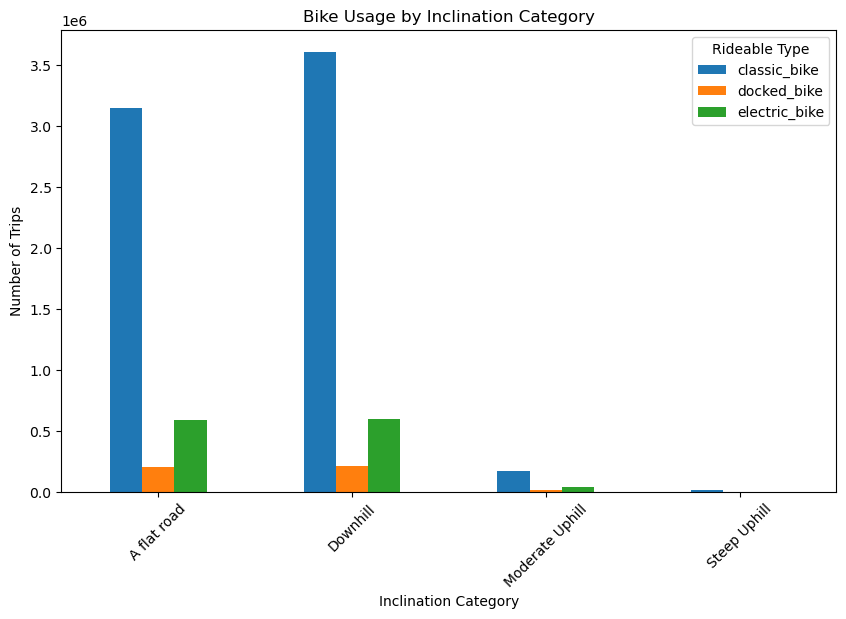

In [ ]:
import matplotlib.pyplot as plt

# Plot the data
bike_usage_by_inclination.plot(kind='bar', figsize=(10, 6))

# Labels and title
plt.xlabel("Inclination Category")
plt.ylabel("Number of Trips")
plt.title("Bike Usage by Inclination Category")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend(title="Rideable Type")

# Show the plot
plt.show()

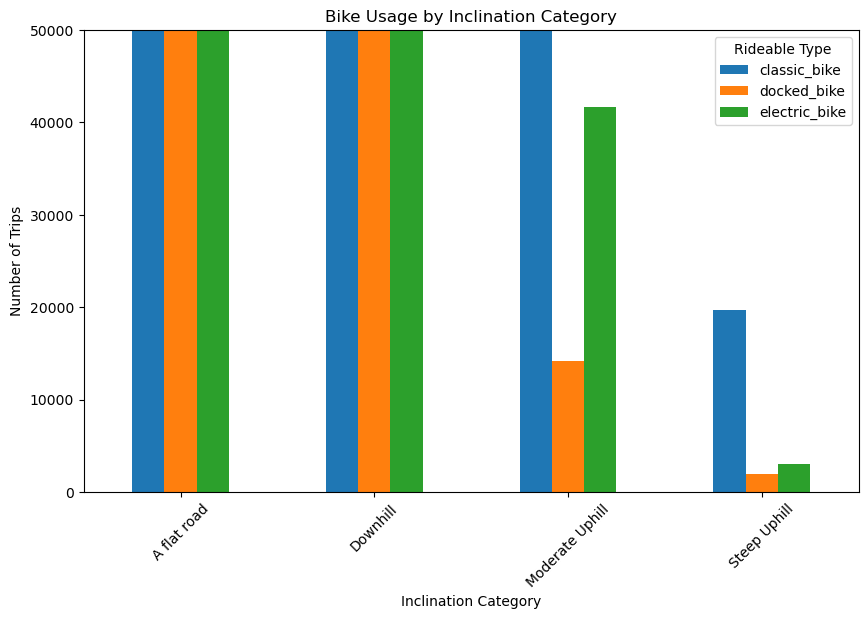

In [ ]:
ax = bike_usage_by_inclination.plot(kind='bar', figsize=(10, 6))

# Labels and title
plt.xlabel("Inclination Category")
plt.ylabel("Number of Trips")
plt.title("Bike Usage by Inclination Category")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend(title="Rideable Type")

# Set y-axis limits
plt.ylim(0, 50000)

# Show the plot
plt.show()


In [ ]:
electric_bikes_elevation

,start_station_name,elevation,Supply_Status,net_demand,Supply_Status_Encoded
0,Maine Ave & 9th St SW,3.0,Oversupplied,-11.0,1
1,10th & U St NW,31.0,Oversupplied,-183.0,1
2,17th & Corcoran St NW,29.0,Oversupplied,-155.0,1
3,Wilson Blvd. & N. Vermont St.,82.0,Oversupplied,-10.0,1
4,11th & Park Rd NW,60.0,Undersupplied,183.0,-1
...,...,...,...,...,...
844,Massachusetts & Idaho Ave NW,103.0,Perfect,-2.0,0
845,Dorr Ave & Prosperity Ave,106.0,Perfect,-1.0,0
846,Tyco Rd & Boyd Pointe Way,119.0,Perfect,0.0,0
847,Old Meadow Rd & Cathy Ln,121.0,Perfect,2.0,0


In [ ]:
import folium
from folium.plugins import HeatMap

# Assuming electric_bikes_elevation contains elevation and station_names_with_elevation contains coordinates

# Merge the two dataframes on 'start_station_name'
elevation = pd.merge(elevation, electric_bikes_elevation[['start_station_name']], 
                                  on='start_station_name', how='left')

# Filter relevant columns: latitude, longitude, and elevation
heat_data = elevation[['latitude', 'longitude', 'elevation']]

# Drop rows with missing elevation data
heat_data = heat_data.dropna(subset=['elevation'])

# Create a map centered around the mean latitude and longitude of all stations
map_center = [heat_data['latitude'].mean(), heat_data['longitude'].mean()]
mymap = folium.Map(location=map_center, zoom_start=12)

# Prepare the heatmap data: latitude, longitude, and elevation as intensity
heat_data_list = heat_data[['latitude', 'longitude', 'elevation']].values.tolist()

# Add the heatmap to the map (using elevation as intensity)
HeatMap(heat_data_list).add_to(mymap)

# Save the map as an HTML file
mymap.save("elevation_heatmap.html")

# Display the map in Jupyter Notebook
mymap



In [ ]:
# Filter relevant columns: latitude, longitude, and elevation
heat_data = elevation[['latitude', 'longitude', 'elevation']]

# Drop rows with missing elevation data
heat_data = heat_data.dropna(subset=['elevation'])

# Create a map centered around the mean latitude and longitude of all stations
map_center = [heat_data['latitude'].mean(), heat_data['longitude'].mean()]
mymap1 = folium.Map(location=map_center, zoom_start=12)

# Prepare the heatmap data: latitude, longitude, and elevation as intensity
heat_data_list = heat_data[['latitude', 'longitude', 'elevation']].values.tolist()

# Add the heatmap to the map (using elevation as intensity)
HeatMap(heat_data_list).add_to(mymap1)

# Save the map as an HTML file
mymap1.save("elevation_heatmap2.html")

# Display the map in Jupyter Notebook
mymap1



In [ ]:
routes['inclination_category'].unique()

array(['A flat road', 'Downhill', 'Moderate Uphill', 'Steep Uphill'],
      dtype=object)

Are tourists or casual rides discouraged from riding steep areas?

In [ ]:
routes

,rideable_type,started_at,ended_at,start_station_name,end_station_name,start_lat,start_lng,end_lat,end_lng,member_casual,...,was_dropped,start_elevation,end_elevation,elevation_change,start_elevation_label,end_elevation_label,distance_meters,inclination_percent,inclination_category,year
0,classic_bike,2021-01-01 00:08:33,2021-01-01 00:33:53,Maine Ave & 9th St SW,Rosslyn Metro / Wilson Blvd & Ft Myer Dr,38.880440,-77.025236,38.894600,-77.072305,member,...,False,3.0,51.0,48.0,low,medium,4367.592696,1.099004,A flat road,2021
2,electric_bike,2021-01-01 00:14:32,2021-01-01 00:28:45,17th & Corcoran St NW,14th & Belmont St NW,38.912138,-77.038568,38.920870,-77.031691,member,...,False,29.0,51.0,22.0,medium,medium,1138.842581,1.931786,A flat road,2021
4,classic_bike,2021-01-01 00:17:46,2021-01-01 00:21:00,11th & Park Rd NW,14th & Newton St NW,38.931322,-77.028247,38.931991,-77.032956,member,...,False,60.0,62.0,2.0,medium,medium,414.049529,0.483034,A flat road,2021
6,classic_bike,2021-01-01 00:19:06,2021-01-01 00:36:28,Bladensburg Rd & Benning Rd NE,Good Hope Rd & MLK Ave SE,38.900413,-76.982872,38.867373,-76.988039,casual,...,False,11.0,12.0,1.0,low,low,3701.002226,0.027020,A flat road,2021
8,docked_bike,2021-01-01 00:21:19,2021-01-01 00:33:31,15th & F St NE,1st & M St SE,38.897195,-76.983575,38.876893,-77.006072,casual,...,False,18.0,8.0,-10.0,low,low,2981.222620,-0.335433,Downhill,2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10693990,classic_bike,2023-12-31 23:57:53,2024-01-01 00:13:53,18th & New Hampshire Ave NW,17th & K St NW,38.911268,-77.041829,38.902760,-77.038630,member,...,False,33.0,34.0,1.0,medium,medium,985.709921,0.101450,A flat road,2023
10693991,classic_bike,2023-12-31 23:57:56,2024-01-01 00:02:25,Eastern Market Metro / Pennsylvania Ave & 8th ...,Lincoln Park / 13th & East Capitol St NE,38.884095,-76.995234,38.890461,-76.988355,casual,...,False,21.0,28.0,7.0,medium,medium,924.983952,0.756770,A flat road,2023
10693992,classic_bike,2023-12-31 23:58:06,2024-01-01 00:12:29,King St & Peyton St,Market Square / King St & Royal St,38.806002,-77.055911,38.804718,-77.043363,member,...,False,11.0,16.0,5.0,low,low,1096.641932,0.455937,A flat road,2023
10693993,electric_bike,2023-12-31 23:58:27,2024-01-01 00:02:28,Eastern Market Metro / Pennsylvania Ave & 8th ...,Lincoln Park / 13th & East Capitol St NE,38.884185,-76.995396,38.890461,-76.988355,member,...,False,21.0,28.0,7.0,medium,medium,926.459560,0.755565,A flat road,2023


In [ ]:
routes_uphill = routes[routes['inclination_category'].isin(['Steep Uphill'])]

In [ ]:
routes_uphill

,rideable_type,started_at,ended_at,start_station_name,end_station_name,start_lat,start_lng,end_lat,end_lng,member_casual,...,was_dropped,start_elevation,end_elevation,elevation_change,start_elevation_label,end_elevation_label,distance_meters,inclination_percent,inclination_category,year
343,classic_bike,2021-01-01 09:43:33,2021-01-01 11:18:23,Lynn St & 19th St North,Rosslyn Metro / Wilson Blvd & Ft Myer Dr,38.897315,-77.070993,38.894600,-77.072305,member,...,False,33.0,51.0,18.0,medium,medium,322.539991,5.580703,Steep Uphill,2021
359,docked_bike,2021-01-01 09:55:42,2021-01-01 10:15:50,New Jersey Ave & F St NW,North Capitol St & F St NW,38.897108,-77.011616,38.897446,-77.009888,casual,...,False,15.0,31.0,16.0,low,medium,154.191761,10.376689,Steep Uphill,2021
361,docked_bike,2021-01-01 09:56:15,2021-01-01 10:15:55,New Jersey Ave & F St NW,North Capitol St & F St NW,38.897108,-77.011616,38.897446,-77.009888,casual,...,False,15.0,31.0,16.0,low,medium,154.191761,10.376689,Steep Uphill,2021
1080,docked_bike,2021-01-02 07:59:43,2021-01-02 09:54:01,17th & G St NW,18th St & Pennsylvania Ave NW,38.898283,-77.039732,38.899680,-77.041539,casual,...,False,28.0,46.0,18.0,medium,medium,220.415841,8.166382,Steep Uphill,2021
1083,docked_bike,2021-01-02 08:05:00,2021-01-02 09:54:09,17th & G St NW,18th St & Pennsylvania Ave NW,38.898283,-77.039732,38.899680,-77.041539,casual,...,False,28.0,46.0,18.0,medium,medium,220.415841,8.166382,Steep Uphill,2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10691610,classic_bike,2023-12-31 16:37:45,2023-12-31 17:16:13,Columbia Pike & S Greenbrier St,8th Rd & S Frederick St,38.854019,-77.118106,38.857049,-77.116339,member,...,False,57.0,76.0,19.0,medium,high,370.035617,5.134641,Steep Uphill,2023
10691612,classic_bike,2023-12-31 16:38:14,2023-12-31 17:47:11,10th & K St NW,12th St & New York Ave NW,38.902400,-77.026220,38.901104,-77.028061,casual,...,False,17.0,34.0,17.0,low,medium,214.818548,7.913656,Steep Uphill,2023
10691616,classic_bike,2023-12-31 16:38:28,2023-12-31 17:47:14,10th & K St NW,12th St & New York Ave NW,38.902400,-77.026220,38.901104,-77.028061,casual,...,False,17.0,34.0,17.0,low,medium,214.818548,7.913656,Steep Uphill,2023
10691638,electric_bike,2023-12-31 16:40:09,2023-12-31 17:47:48,10th & K St NW,12th St & New York Ave NW,38.902532,-77.026183,38.901104,-77.028061,casual,...,False,17.0,34.0,17.0,low,medium,227.202068,7.482326,Steep Uphill,2023


Time

In [ ]:
routes_uphill['started_at'] = pd.to_datetime(routes_uphill['started_at'])  # change to datetime format
routes_uphill['ended_at'] = pd.to_datetime(routes_uphill['ended_at'])

D:\Users\Olunia\AppData\Local\Temp\ipykernel_15328\1660495814.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  routes_uphill['started_at'] = pd.to_datetime(routes_uphill['started_at'])  # change to datetime format
D:\Users\Olunia\AppData\Local\Temp\ipykernel_15328\1660495814.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  routes_uphill['ended_at'] = pd.to_datetime(routes_uphill['ended_at'])


In [ ]:
routes['started_at'] = pd.to_datetime(routes['started_at'])  # change to datetime format
routes['ended_at'] = pd.to_datetime(routes['ended_at'])
routes['trip_duration'] = routes['ended_at'] - routes['started_at']
routes['trip_duration_minutes'] = (routes['trip_duration'].dt.total_seconds() / 60).round(0)

In [ ]:
routes_uphill['trip_duration'] = routes_uphill['ended_at'] - routes_uphill['started_at']


D:\Users\Olunia\AppData\Local\Temp\ipykernel_15328\3081609016.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  routes_uphill['trip_duration'] = routes_uphill['ended_at'] - routes_uphill['started_at']


In [ ]:
routes_uphill['trip_duration_minutes'] = (routes_uphill['trip_duration'].dt.total_seconds() / 60).round(0)

D:\Users\Olunia\AppData\Local\Temp\ipykernel_15328\3050000542.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  routes_uphill['trip_duration_minutes'] = (routes_uphill['trip_duration'].dt.total_seconds() / 60).round(0)


In [ ]:
routes_uphill

,rideable_type,started_at,ended_at,start_station_name,end_station_name,start_lat,start_lng,end_lat,end_lng,member_casual,...,start_elevation,end_elevation,elevation_change,start_elevation_label,end_elevation_label,distance_meters,inclination_percent,inclination_category,year,trip_duration
343,classic_bike,2021-01-01 09:43:33,2021-01-01 11:18:23,Lynn St & 19th St North,Rosslyn Metro / Wilson Blvd & Ft Myer Dr,38.897315,-77.070993,38.894600,-77.072305,member,...,33.0,51.0,18.0,medium,medium,322.539991,5.580703,Steep Uphill,2021,0 days 01:34:50
359,docked_bike,2021-01-01 09:55:42,2021-01-01 10:15:50,New Jersey Ave & F St NW,North Capitol St & F St NW,38.897108,-77.011616,38.897446,-77.009888,casual,...,15.0,31.0,16.0,low,medium,154.191761,10.376689,Steep Uphill,2021,0 days 00:20:08
361,docked_bike,2021-01-01 09:56:15,2021-01-01 10:15:55,New Jersey Ave & F St NW,North Capitol St & F St NW,38.897108,-77.011616,38.897446,-77.009888,casual,...,15.0,31.0,16.0,low,medium,154.191761,10.376689,Steep Uphill,2021,0 days 00:19:40
1080,docked_bike,2021-01-02 07:59:43,2021-01-02 09:54:01,17th & G St NW,18th St & Pennsylvania Ave NW,38.898283,-77.039732,38.899680,-77.041539,casual,...,28.0,46.0,18.0,medium,medium,220.415841,8.166382,Steep Uphill,2021,0 days 01:54:18
1083,docked_bike,2021-01-02 08:05:00,2021-01-02 09:54:09,17th & G St NW,18th St & Pennsylvania Ave NW,38.898283,-77.039732,38.899680,-77.041539,casual,...,28.0,46.0,18.0,medium,medium,220.415841,8.166382,Steep Uphill,2021,0 days 01:49:09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10691610,classic_bike,2023-12-31 16:37:45,2023-12-31 17:16:13,Columbia Pike & S Greenbrier St,8th Rd & S Frederick St,38.854019,-77.118106,38.857049,-77.116339,member,...,57.0,76.0,19.0,medium,high,370.035617,5.134641,Steep Uphill,2023,0 days 00:38:28
10691612,classic_bike,2023-12-31 16:38:14,2023-12-31 17:47:11,10th & K St NW,12th St & New York Ave NW,38.902400,-77.026220,38.901104,-77.028061,casual,...,17.0,34.0,17.0,low,medium,214.818548,7.913656,Steep Uphill,2023,0 days 01:08:57
10691616,classic_bike,2023-12-31 16:38:28,2023-12-31 17:47:14,10th & K St NW,12th St & New York Ave NW,38.902400,-77.026220,38.901104,-77.028061,casual,...,17.0,34.0,17.0,low,medium,214.818548,7.913656,Steep Uphill,2023,0 days 01:08:46
10691638,electric_bike,2023-12-31 16:40:09,2023-12-31 17:47:48,10th & K St NW,12th St & New York Ave NW,38.902532,-77.026183,38.901104,-77.028061,casual,...,17.0,34.0,17.0,low,medium,227.202068,7.482326,Steep Uphill,2023,0 days 01:07:39


In [ ]:
routes_uphill[['started_at', 'ended_at', 'trip_duration', 'trip_duration_minutes','distance_meters']]

,started_at,ended_at,trip_duration,trip_duration_minutes,distance_meters
343,2021-01-01 09:43:33,2021-01-01 11:18:23,0 days 01:34:50,95.0,322.539991
359,2021-01-01 09:55:42,2021-01-01 10:15:50,0 days 00:20:08,20.0,154.191761
361,2021-01-01 09:56:15,2021-01-01 10:15:55,0 days 00:19:40,20.0,154.191761
1080,2021-01-02 07:59:43,2021-01-02 09:54:01,0 days 01:54:18,114.0,220.415841
1083,2021-01-02 08:05:00,2021-01-02 09:54:09,0 days 01:49:09,109.0,220.415841
...,...,...,...,...,...
10691610,2023-12-31 16:37:45,2023-12-31 17:16:13,0 days 00:38:28,38.0,370.035617
10691612,2023-12-31 16:38:14,2023-12-31 17:47:11,0 days 01:08:57,69.0,214.818548
10691616,2023-12-31 16:38:28,2023-12-31 17:47:14,0 days 01:08:46,69.0,214.818548
10691638,2023-12-31 16:40:09,2023-12-31 17:47:48,0 days 01:07:39,68.0,227.202068


In [ ]:
# Filter for trips with distance greater than or equal to 600 meters
long_routes_uphill = routes_uphill[routes_uphill['distance_meters'] >= 600]

# Filter for trips with duration greater than or equal to 5 minutes (assuming trip_duration_minutes column exists)
long_routes_uphill = long_routes_uphill[long_routes_uphill['trip_duration_minutes'] >= 5]

# Then, filter out consecutive rows with the same start and end stations
same_stations = (long_routes_uphill['start_station_name'] == long_routes_uphill['start_station_name'].shift()) & \
                (long_routes_uphill['end_station_name'] == long_routes_uphill['end_station_name'].shift())

# Finally, remove those consecutive trips
filtered_routes_uphill = long_routes_uphill[~same_stations]

# Display the filtered DataFrame
filtered_routes_uphill


,rideable_type,started_at,ended_at,start_station_name,end_station_name,start_lat,start_lng,end_lat,end_lng,member_casual,...,start_elevation,end_elevation,elevation_change,start_elevation_label,end_elevation_label,distance_meters,inclination_percent,inclination_category,year,trip_duration
4891,electric_bike,2021-01-02 15:52:08,2021-01-02 16:56:04,Maple & Ritchie Ave,Carroll & Ethan Allen Ave,38.983606,-77.006250,38.977952,-77.006383,casual,...,62.0,90.0,28.0,medium,high,628.799642,4.452929,Steep Uphill,2021,0 days 01:03:56
5306,classic_bike,2021-01-02 16:28:02,2021-01-02 16:42:28,Roosevelt Island,15th St & N Scott St,38.896553,-77.067140,38.890540,-77.080950,casual,...,15.0,79.0,64.0,low,high,1369.489711,4.673274,Steep Uphill,2021,0 days 00:14:26
5503,classic_bike,2021-01-02 16:50:05,2021-01-02 16:59:11,Lynn St & 19th St North,15th St & N Scott St,38.897315,-77.070993,38.890540,-77.080950,member,...,33.0,79.0,46.0,medium,high,1144.591689,4.018900,Steep Uphill,2021,0 days 00:09:06
5906,classic_bike,2021-01-02 18:01:17,2021-01-02 18:14:23,Iwo Jima Memorial / Meade & 14th St N,15th St & N Scott St,38.889920,-77.071301,38.890540,-77.080950,member,...,45.0,79.0,34.0,medium,high,837.948210,4.057530,Steep Uphill,2021,0 days 00:13:06
9224,classic_bike,2021-01-04 12:14:29,2021-01-04 12:20:05,14th & V St NW,15th & Euclid St NW,38.917764,-77.032096,38.923330,-77.035200,member,...,38.0,66.0,28.0,medium,medium,674.604679,4.150579,Steep Uphill,2021,0 days 00:05:36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10679217,classic_bike,2023-12-30 01:14:39,2023-12-30 01:20:05,14th & V St NW,15th & Euclid St NW,38.917764,-77.032096,38.923330,-77.035200,member,...,38.0,66.0,28.0,medium,medium,674.604679,4.150579,Steep Uphill,2023,0 days 00:05:26
10680675,electric_bike,2023-12-30 11:21:24,2023-12-30 11:26:22,21st St & N Pierce St,Wilson Blvd & N Uhle St,38.898991,-77.078391,38.891696,-77.084600,member,...,42.0,85.0,43.0,medium,high,972.966646,4.419473,Steep Uphill,2023,0 days 00:04:58
10681591,classic_bike,2023-12-30 12:48:50,2023-12-30 12:59:22,Maple & Ritchie Ave,Carroll & Ethan Allen Ave,38.983627,-77.006311,38.977933,-77.006472,casual,...,62.0,90.0,28.0,medium,high,633.296837,4.421307,Steep Uphill,2023,0 days 00:10:32
10685162,electric_bike,2023-12-30 18:15:15,2023-12-30 18:22:53,Harvard St & Adams Mill Rd NW,3000 Connecticut Ave NW / National Zoo,38.927878,-77.043271,38.930282,-77.055599,member,...,29.0,75.0,46.0,medium,high,1099.361710,4.184246,Steep Uphill,2023,0 days 00:07:38


In [ ]:
filtered_routes_uphill['rideable_type'].value_counts()

rideable_type
classic_bike     3127
electric_bike     611
docked_bike       159
Name: count, dtype: int64

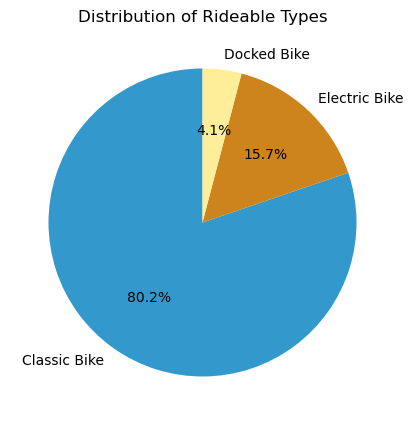

In [ ]:
plt.figure(figsize=(5, 5))
plt.pie(filtered_routes_uphill['rideable_type'].value_counts(), labels = ["Classic Bike", "Electric Bike", "Docked Bike"], autopct='%1.1f%%', startangle=90, colors=['#3399cc', '#ce841c', '#ffee99'])
plt.title('Distribution of Rideable Types')
plt.show()

In [ ]:
filtered_routes_uphill['member_casual'].value_counts()

member_casual
member    2541
casual    1356
Name: count, dtype: int64

In [ ]:
routes_uphill['distance_meters'].max()

1913.2953838296505

In [ ]:
long_trips_uphill = routes_uphill[routes_uphill['trip_duration_minutes'] > 5]
long_trips_uphill[['start_station_name', 'end_station_name', 'trip_duration_minutes']]

,start_station_name,end_station_name,trip_duration_minutes
343,Lynn St & 19th St North,Rosslyn Metro / Wilson Blvd & Ft Myer Dr,95.0
359,New Jersey Ave & F St NW,North Capitol St & F St NW,20.0
361,New Jersey Ave & F St NW,North Capitol St & F St NW,20.0
1080,17th & G St NW,18th St & Pennsylvania Ave NW,114.0
1083,17th & G St NW,18th St & Pennsylvania Ave NW,109.0
...,...,...,...
10691610,Columbia Pike & S Greenbrier St,8th Rd & S Frederick St,38.0
10691612,10th & K St NW,12th St & New York Ave NW,69.0
10691616,10th & K St NW,12th St & New York Ave NW,69.0
10691638,10th & K St NW,12th St & New York Ave NW,68.0


In [ ]:
routes_flat = routes[routes['inclination_category'].isin(['A flat road', 'Moderate Uphill'])]

In [ ]:
routes_flat['started_at'] = pd.to_datetime(routes_flat['started_at'])  # change to datetime format
routes_flat['ended_at'] = pd.to_datetime(routes_flat['ended_at'])

D:\Users\Olunia\AppData\Local\Temp\ipykernel_15328\3398232180.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  routes_flat['started_at'] = pd.to_datetime(routes_flat['started_at'])  # change to datetime format
D:\Users\Olunia\AppData\Local\Temp\ipykernel_15328\3398232180.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  routes_flat['ended_at'] = pd.to_datetime(routes_flat['ended_at'])


In [ ]:
routes_flat['trip_duration'] = routes_flat['ended_at'] - routes_flat['started_at']
routes_flat['trip_duration_minutes'] = (routes_flat['trip_duration'].dt.total_seconds() / 60).round(0)

D:\Users\Olunia\AppData\Local\Temp\ipykernel_15328\3089272075.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  routes_flat['trip_duration'] = routes_flat['ended_at'] - routes_flat['started_at']
D:\Users\Olunia\AppData\Local\Temp\ipykernel_15328\3089272075.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  routes_flat['trip_duration_minutes'] = (routes_flat['trip_duration'].dt.total_seconds() / 60).round(0)


In [ ]:
long_trips_flat = routes_flat[routes_flat['trip_duration_minutes'] > 5]
long_trips_flat[['start_station_name', 'end_station_name', 'trip_duration_minutes']]

,start_station_name,end_station_name,trip_duration_minutes
0,Maine Ave & 9th St SW,Rosslyn Metro / Wilson Blvd & Ft Myer Dr,25.0
2,17th & Corcoran St NW,14th & Belmont St NW,14.0
6,Bladensburg Rd & Benning Rd NE,Good Hope Rd & MLK Ave SE,17.0
11,Henry Bacon Dr & Lincoln Memorial Circle NW,14th St & New York Ave NW,24.0
12,Henry Bacon Dr & Lincoln Memorial Circle NW,14th St & New York Ave NW,24.0
...,...,...,...
10693984,17th & P St NW,Georgia Ave & Morton St NW,18.0
10693986,Smithsonian-National Mall / Jefferson Dr & 12t...,Independence Ave & L'Enfant Plaza SW/DOE,81.0
10693990,18th & New Hampshire Ave NW,17th & K St NW,16.0
10693992,King St & Peyton St,Market Square / King St & Royal St,14.0


In [ ]:
# Oblicz średni czas trwania podróży w minutach dla tras uphill
average_uphill_time = routes_uphill['trip_duration_minutes'].mean()

# Oblicz średni czas trwania podróży w minutach dla tras płaskich
average_flat_time = routes_flat['trip_duration_minutes'].mean()

# Wyświetl średnie czasy
print(f"Średni czas podróży uphill: {average_uphill_time} minut")
print(f"Średni czas podróży flat: {average_flat_time} minut")


Średni czas podróży uphill: 25.539863879436073 minut
Średni czas podróży flat: 20.693372561528108 minut


In [ ]:
# Filtruj trasy uphill z określoną odległością
uphill_filtered = routes_uphill[(routes_uphill['distance_meters'] >= 500) & (routes_uphill['distance_meters'] <= 1000)]

# Filtruj trasy flat z określoną odległością
flat_filtered = routes_flat[(routes_flat['distance_meters'] >= 500) & (routes_flat['distance_meters'] <= 1000)]


In [ ]:
# Oblicz czas na metr dla tras uphill
uphill_filtered['time_per_meter'] = uphill_filtered['trip_duration_minutes'] * 60 / uphill_filtered['distance_meters']

# Oblicz czas na metr dla tras flat
flat_filtered['time_per_meter'] = flat_filtered['trip_duration_minutes'] * 60 / flat_filtered['distance_meters']

# Oblicz średni czas na metr dla obu typów tras
average_uphill_time_per_meter = uphill_filtered['time_per_meter'].mean()
average_flat_time_per_meter = flat_filtered['time_per_meter'].mean()

# Wyświetl wyniki
print(f"Średni czas na metr dla tras uphill: {average_uphill_time_per_meter:.4f} sekund")
print(f"Średni czas na metr dla tras flat: {average_flat_time_per_meter:.4f} sekund")

Średni czas na metr dla tras uphill: 1.6626 sekund
Średni czas na metr dla tras flat: 1.0145 sekund


D:\Users\Olunia\AppData\Local\Temp\ipykernel_15328\3409336355.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uphill_filtered['time_per_meter'] = uphill_filtered['trip_duration_minutes'] * 60 / uphill_filtered['distance_meters']
D:\Users\Olunia\AppData\Local\Temp\ipykernel_15328\3409336355.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flat_filtered['time_per_meter'] = flat_filtered['trip_duration_minutes'] * 60 / flat_filtered['distance_meters']


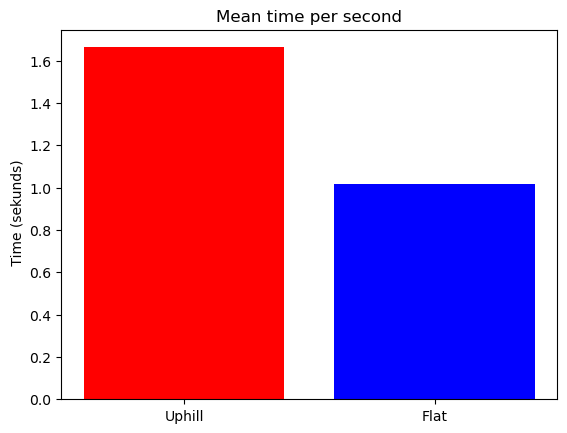

In [ ]:
import matplotlib.pyplot as plt

# Wykres porównania średnich czasów na metr
labels = ['Uphill', 'Flat']
times_per_meter = [average_uphill_time_per_meter, average_flat_time_per_meter]

plt.bar(labels, times_per_meter, color=['red', 'blue'])
plt.title('Mean time per second')
plt.ylabel(' Time (sekunds)')
plt.show()



In [ ]:
routes

,rideable_type,started_at,ended_at,start_station_name,end_station_name,start_lat,start_lng,end_lat,end_lng,member_casual,...,start_elevation,end_elevation,elevation_change,start_elevation_label,end_elevation_label,distance_meters,inclination_percent,inclination_category,year,trip_duration
0,classic_bike,2021-01-01 00:08:33,2021-01-01 00:33:53,Maine Ave & 9th St SW,Rosslyn Metro / Wilson Blvd & Ft Myer Dr,38.880440,-77.025236,38.894600,-77.072305,member,...,3.0,51.0,48.0,low,medium,4367.592696,1.099004,A flat road,2021,0 days 00:25:20
2,electric_bike,2021-01-01 00:14:32,2021-01-01 00:28:45,17th & Corcoran St NW,14th & Belmont St NW,38.912138,-77.038568,38.920870,-77.031691,member,...,29.0,51.0,22.0,medium,medium,1138.842581,1.931786,A flat road,2021,0 days 00:14:13
4,classic_bike,2021-01-01 00:17:46,2021-01-01 00:21:00,11th & Park Rd NW,14th & Newton St NW,38.931322,-77.028247,38.931991,-77.032956,member,...,60.0,62.0,2.0,medium,medium,414.049529,0.483034,A flat road,2021,0 days 00:03:14
6,classic_bike,2021-01-01 00:19:06,2021-01-01 00:36:28,Bladensburg Rd & Benning Rd NE,Good Hope Rd & MLK Ave SE,38.900413,-76.982872,38.867373,-76.988039,casual,...,11.0,12.0,1.0,low,low,3701.002226,0.027020,A flat road,2021,0 days 00:17:22
8,docked_bike,2021-01-01 00:21:19,2021-01-01 00:33:31,15th & F St NE,1st & M St SE,38.897195,-76.983575,38.876893,-77.006072,casual,...,18.0,8.0,-10.0,low,low,2981.222620,-0.335433,Downhill,2021,0 days 00:12:12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10693990,classic_bike,2023-12-31 23:57:53,2024-01-01 00:13:53,18th & New Hampshire Ave NW,17th & K St NW,38.911268,-77.041829,38.902760,-77.038630,member,...,33.0,34.0,1.0,medium,medium,985.709921,0.101450,A flat road,2023,0 days 00:16:00
10693991,classic_bike,2023-12-31 23:57:56,2024-01-01 00:02:25,Eastern Market Metro / Pennsylvania Ave & 8th ...,Lincoln Park / 13th & East Capitol St NE,38.884095,-76.995234,38.890461,-76.988355,casual,...,21.0,28.0,7.0,medium,medium,924.983952,0.756770,A flat road,2023,0 days 00:04:29
10693992,classic_bike,2023-12-31 23:58:06,2024-01-01 00:12:29,King St & Peyton St,Market Square / King St & Royal St,38.806002,-77.055911,38.804718,-77.043363,member,...,11.0,16.0,5.0,low,low,1096.641932,0.455937,A flat road,2023,0 days 00:14:23
10693993,electric_bike,2023-12-31 23:58:27,2024-01-01 00:02:28,Eastern Market Metro / Pennsylvania Ave & 8th ...,Lincoln Park / 13th & East Capitol St NE,38.884185,-76.995396,38.890461,-76.988355,member,...,21.0,28.0,7.0,medium,medium,926.459560,0.755565,A flat road,2023,0 days 00:04:01


In [ ]:
routes.isna().sum()

rideable_type            0
started_at               0
ended_at                 0
start_station_name       0
end_station_name         0
start_lat                0
start_lng                0
end_lat                  0
end_lng                  0
member_casual            0
trip_duration_minutes    0
was_dropped              0
start_elevation          0
end_elevation            0
elevation_change         0
start_elevation_label    0
end_elevation_label      0
distance_meters          0
inclination_percent      0
inclination_category     0
year                     0
trip_duration            0
dtype: int64

In [ ]:
# Średni czas podróży dla rowerów elektrycznych i klasycznych - uphill
average_uphill_electric = routes_uphill[routes_uphill['rideable_type'] == 'electric_bike']['trip_duration_minutes'].mean()
average_uphill_classic = routes_uphill[routes_uphill['rideable_type'] == 'classic_bike']['trip_duration_minutes'].mean()

# Średni czas podróży dla rowerów elektrycznych i klasycznych - flat
average_flat_electric = routes_flat[routes_flat['rideable_type'] == 'electric_bike']['trip_duration_minutes'].mean()
average_flat_classic = routes_flat[routes_flat['rideable_type'] == 'classic_bike']['trip_duration_minutes'].mean()

# Wyświetl średnie czasy
print(f"Średni czas podróży uphill (electric): {average_uphill_electric:.2f} minut")
print(f"Średni czas podróży uphill (classic): {average_uphill_classic:.2f} minut")
print(f"Średni czas podróży flat (electric): {average_flat_electric:.2f} minut")
print(f"Średni czas podróży flat (classic): {average_flat_classic:.2f} minut")


Średni czas podróży uphill (electric): 17.87 minut
Średni czas podróży uphill (classic): 21.32 minut
Średni czas podróży flat (electric): 14.90 minut
Średni czas podróży flat (classic): 17.94 minut


In [ ]:
# Oblicz procentową różnicę w czasie podróży dla uphill i flat
percent_faster_uphill = (average_uphill_classic - average_uphill_electric) / average_uphill_classic * 100
percent_faster_flat = (average_flat_classic - average_flat_electric) / average_flat_classic * 100

# Wyświetl wyniki
print(f"Rowery elektryczne są o {percent_faster_uphill:.2f}% szybsze na uphill trasach.")
print(f"Rowery elektryczne są o {percent_faster_flat:.2f}% szybsze na płaskich trasach.")


Rowery elektryczne są o 16.19% szybsze na uphill trasach.
Rowery elektryczne są o 16.96% szybsze na płaskich trasach.


Moze jakies outliers?

In [ ]:
# Oblicz Q1 (25 percentyl) i Q3 (75 percentyl)
Q1 = uphill_filtered['time_per_meter'].quantile(0.25)
Q3 = uphill_filtered['time_per_meter'].quantile(0.75)
IQR = Q3 - Q1

# Zdefiniuj dolną i górną granicę dla outlierów
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Znajdź wartości odstające
outliers_uphill = uphill_filtered[(uphill_filtered['time_per_meter'] < lower_bound) | 
                           (uphill_filtered['time_per_meter'] > upper_bound)]

outliers_uphill


,rideable_type,started_at,ended_at,start_station_name,end_station_name,start_lat,start_lng,end_lat,end_lng,member_casual,...,end_elevation,elevation_change,start_elevation_label,end_elevation_label,distance_meters,inclination_percent,inclination_category,year,trip_duration,time_per_meter
4891,electric_bike,2021-01-02 15:52:08,2021-01-02 16:56:04,Maple & Ritchie Ave,Carroll & Ethan Allen Ave,38.983606,-77.006250,38.977952,-77.006383,casual,...,90.0,28.0,medium,high,628.799642,4.452929,Steep Uphill,2021,0 days 01:03:56,6.106874
13057,classic_bike,2021-01-05 15:25:57,2021-01-05 16:39:57,15th St & Constitution Ave NW,14th St & New York Ave NW,38.892244,-77.033234,38.899632,-77.031686,casual,...,42.0,34.0,low,medium,832.359658,4.084773,Steep Uphill,2021,0 days 01:14:00,5.334233
31931,electric_bike,2021-01-11 06:37:55,2021-01-11 07:07:32,14th & V St NW,15th & Euclid St NW,38.917939,-77.031870,38.923296,-77.035224,member,...,66.0,28.0,medium,medium,662.589813,4.225842,Steep Uphill,2021,0 days 00:29:37,2.716613
56223,classic_bike,2021-01-17 15:00:38,2021-01-17 16:21:33,34th & Water St NW,37th & O St NW / Georgetown University,38.903731,-77.067528,38.907740,-77.071652,casual,...,48.0,37.0,low,medium,570.947121,6.480460,Steep Uphill,2021,0 days 01:20:55,8.512172
56228,classic_bike,2021-01-17 15:01:27,2021-01-17 16:20:17,34th & Water St NW,37th & O St NW / Georgetown University,38.903731,-77.067528,38.907740,-77.071652,casual,...,48.0,37.0,low,medium,570.947121,6.480460,Steep Uphill,2021,0 days 01:18:50,8.301995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10586411,classic_bike,2023-12-16 15:22:56,2023-12-16 16:21:00,Harvard St & Adams Mill Rd NW,16th & Harvard St NW,38.927872,-77.043358,38.926102,-77.036650,member,...,65.0,36.0,medium,medium,612.736847,5.875279,Steep Uphill,2023,0 days 00:58:04,5.679436
10586890,electric_bike,2023-12-16 15:46:32,2023-12-16 16:26:26,Rosslyn Metro / Wilson Blvd & N Moore St,Clarendon Blvd & Pierce St,38.896144,-77.071541,38.893438,-77.076389,casual,...,70.0,30.0,medium,medium,516.292940,5.810655,Steep Uphill,2023,0 days 00:39:54,4.648524
10647127,classic_bike,2023-12-23 22:22:51,2023-12-23 23:26:25,Harvard St & Adams Mill Rd NW,Lamont & Mt Pleasant NW,38.927872,-77.043358,38.931900,-77.038800,member,...,66.0,37.0,medium,medium,596.704009,6.200729,Steep Uphill,2023,0 days 01:03:34,6.435351
10663852,electric_bike,2023-12-28 10:43:03,2023-12-28 11:12:40,Potomac & M St NW,37th & O St NW / Georgetown University,38.905527,-77.065203,38.907837,-77.071660,casual,...,48.0,26.0,medium,medium,614.922971,4.228172,Steep Uphill,2023,0 days 00:29:37,2.927196


In [ ]:
print(uphill_filtered[['trip_duration_minutes', 'distance_meters', 'time_per_meter']].sort_values(by='time_per_meter', ascending=False).head(20))
print(flat_filtered[['trip_duration_minutes', 'distance_meters', 'time_per_meter']].sort_values(by='time_per_meter', ascending=False).head(10))


          trip_duration_minutes  distance_meters  time_per_meter
534562                   2974.0       527.580818      338.223063
6280139                  1354.0       571.703895      142.101533
5363192                  1456.0       674.604679      129.498064
3667782                   742.0       527.660970       84.372358
3858840                   919.0       814.693076       67.681930
9615983                   638.0       596.808027       64.141228
5371822                   699.0       674.604679       62.169744
780855                    851.0       857.971432       59.512471
9616654                   583.0       596.808027       58.611812
8886773                   518.0       612.395254       50.751536
4984804                   617.0       731.194642       50.629474
5696419                   402.0       527.580818       45.718114
2944430                   477.0       653.351832       43.804882
1187112                   427.0       596.808027       42.928377
5508204                  

In [ ]:
#Usuwamy te same outliery z całej bazy danych routes na podstawie indeksu
routes_cleaned_uphill = routes.drop(outliers_uphill.index)

# Wyświetl usunięte outliery i nową tabelę
print("Usunięte outliery:")
print(outliers_uphill)

print("\nNowa tabela bez outlierów:")
print(routes_cleaned_uphill)

Usunięte outliery:
          rideable_type          started_at            ended_at  \
4891      electric_bike 2021-01-02 15:52:08 2021-01-02 16:56:04   
13057      classic_bike 2021-01-05 15:25:57 2021-01-05 16:39:57   
31931     electric_bike 2021-01-11 06:37:55 2021-01-11 07:07:32   
56223      classic_bike 2021-01-17 15:00:38 2021-01-17 16:21:33   
56228      classic_bike 2021-01-17 15:01:27 2021-01-17 16:20:17   
...                 ...                 ...                 ...   
10586411   classic_bike 2023-12-16 15:22:56 2023-12-16 16:21:00   
10586890  electric_bike 2023-12-16 15:46:32 2023-12-16 16:26:26   
10647127   classic_bike 2023-12-23 22:22:51 2023-12-23 23:26:25   
10663852  electric_bike 2023-12-28 10:43:03 2023-12-28 11:12:40   
10670424  electric_bike 2023-12-29 00:02:41 2023-12-29 01:02:53   

                                start_station_name  \
4891                           Maple & Ritchie Ave   
13057                15th St & Constitution Ave NW   
31931         

In [ ]:
# Średni czas podróży dla rowerów elektrycznych i klasycznych - uphill
average_uphill_electric = routes_cleaned_uphill[routes_cleaned_uphill['rideable_type'] == 'electric_bike']['trip_duration_minutes'].mean()
average_uphill_classic = routes_cleaned_uphill[routes_cleaned_uphill['rideable_type'] == 'classic_bike']['trip_duration_minutes'].mean()


# Wyświetl średnie czasy
print(f"Średni czas podróży uphill (electric): {average_uphill_electric:.2f} minut")
print(f"Średni czas podróży uphill (classic): {average_uphill_classic:.2f} minut")


Średni czas podróży uphill (electric): 15.07 minut
Średni czas podróży uphill (classic): 17.75 minut


In [ ]:
# Oblicz Q1 (25 percentyl) i Q3 (75 percentyl)
Q1 = flat_filtered['time_per_meter'].quantile(0.25)
Q3 = flat_filtered['time_per_meter'].quantile(0.75)
IQR = Q3 - Q1

# Zdefiniuj dolną i górną granicę dla outlierów
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Znajdź wartości odstające
outliers_flat = flat_filtered[(flat_filtered['time_per_meter'] < lower_bound) | 
                           (flat_filtered['time_per_meter'] > upper_bound)]

outliers_flat

,rideable_type,started_at,ended_at,start_station_name,end_station_name,start_lat,start_lng,end_lat,end_lng,member_casual,...,end_elevation,elevation_change,start_elevation_label,end_elevation_label,distance_meters,inclination_percent,inclination_category,year,trip_duration,time_per_meter
239,classic_bike,2021-01-01 08:07:26,2021-01-01 08:19:21,11th & O St NW,12th & L St NW,38.908430,-77.027140,38.903819,-77.028400,member,...,39.0,6.0,medium,medium,524.183602,1.144637,A flat road,2021,0 days 00:11:55,1.373565
469,electric_bike,2021-01-01 11:15:41,2021-01-01 11:49:40,3rd & H St NE,3rd & M St NE,38.900481,-77.002210,38.905542,-77.002210,member,...,20.0,3.0,low,medium,562.701927,0.533142,A flat road,2021,0 days 00:33:59,3.625365
517,classic_bike,2021-01-01 12:14:33,2021-01-01 12:43:16,11th & S St NW,16th & R St NW,38.913761,-77.027025,38.912652,-77.036278,member,...,32.0,4.0,medium,medium,810.016687,0.493817,A flat road,2021,0 days 00:28:43,2.148104
579,classic_bike,2021-01-01 13:16:29,2021-01-01 13:42:06,14th & R St NW,14th & V St NW,38.913046,-77.032008,38.917764,-77.032096,member,...,38.0,0.0,medium,medium,524.728499,0.000000,A flat road,2021,0 days 00:25:37,2.972966
595,classic_bike,2021-01-01 13:26:43,2021-01-01 14:15:51,Town Center Pkwy & Bowman Towne Dr,Reston Town Center Transit Station,38.962524,-77.361902,38.957037,-77.359718,casual,...,124.0,8.0,high,high,638.681299,1.252581,A flat road,2021,0 days 00:49:08,4.603235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10693221,electric_bike,2023-12-31 20:32:42,2023-12-31 20:45:42,11th & S St NW,14th St & Rhode Island Ave NW,38.913687,-77.027113,38.908600,-77.032300,casual,...,31.0,3.0,medium,medium,722.043363,0.415488,A flat road,2023,0 days 00:13:00,1.080268
10693323,classic_bike,2023-12-31 20:53:19,2023-12-31 21:20:03,5th & K St NW,13th St & New York Ave NW,38.903040,-77.019027,38.900283,-77.029822,member,...,35.0,20.0,low,medium,983.159431,2.034258,Moderate Uphill,2023,0 days 00:26:44,1.647749
10693588,electric_bike,2023-12-31 22:01:11,2023-12-31 23:08:42,14th & D St NW / John A Wilson Building,13th St & New York Ave NW,38.894574,-77.031683,38.900283,-77.029822,member,...,35.0,21.0,low,medium,654.901167,3.206591,Moderate Uphill,2023,0 days 01:07:31,6.229948
10693711,classic_bike,2023-12-31 22:31:20,2023-12-31 22:47:03,8th & H St NW,14th & L St NW,38.899700,-77.023086,38.903658,-77.031737,member,...,39.0,21.0,low,medium,868.398019,2.418246,Moderate Uphill,2023,0 days 00:15:43,1.105484


In [ ]:
#Usuwamy te same outliery z całej bazy danych routes na podstawie indeksu
routes_cleaned_combined = routes_cleaned_uphill.drop(outliers_flat.index)

# Wyświetl usunięte outliery i nową tabelę
print("Usunięte outliery:")
print(outliers_flat)

print("\nNowa tabela bez outlierów:")
print(routes_cleaned_combined)

Usunięte outliery:
          rideable_type          started_at            ended_at  \
239        classic_bike 2021-01-01 08:07:26 2021-01-01 08:19:21   
469       electric_bike 2021-01-01 11:15:41 2021-01-01 11:49:40   
517        classic_bike 2021-01-01 12:14:33 2021-01-01 12:43:16   
579        classic_bike 2021-01-01 13:16:29 2021-01-01 13:42:06   
595        classic_bike 2021-01-01 13:26:43 2021-01-01 14:15:51   
...                 ...                 ...                 ...   
10693221  electric_bike 2023-12-31 20:32:42 2023-12-31 20:45:42   
10693323   classic_bike 2023-12-31 20:53:19 2023-12-31 21:20:03   
10693588  electric_bike 2023-12-31 22:01:11 2023-12-31 23:08:42   
10693711   classic_bike 2023-12-31 22:31:20 2023-12-31 22:47:03   
10693980   classic_bike 2023-12-31 23:52:13 2024-01-01 00:14:14   

                               start_station_name  \
239                                11th & O St NW   
469                                 3rd & H St NE   
517              

In [ ]:
# Filtruj tylko trasy uphill
uphill_routes = routes_cleaned_combined[routes_cleaned_combined['inclination_category'] == 'Steep Uphill']

# Oblicz średni czas podróży dla rowerów elektrycznych i klasycznych - tylko uphill
average_electric_uphill = uphill_routes[uphill_routes['rideable_type'] == 'electric_bike']['trip_duration_minutes'].mean()
average_classic_uphill = uphill_routes[uphill_routes['rideable_type'] == 'classic_bike']['trip_duration_minutes'].mean()

# Wyświetl średnie czasy dla tras uphill
print(f"Średni czas podróży (electric) uphill: {average_electric_uphill:.2f} minut")
print(f"Średni czas podróży (classic) uphill: {average_classic_uphill:.2f} minut")



Średni czas podróży (electric) uphill: 15.86 minut
Średni czas podróży (classic) uphill: 18.93 minut


In [ ]:
routes_cleaned_combined['inclination_category'].unique()

array(['A flat road', 'Downhill', 'Moderate Uphill', 'Steep Uphill'],
      dtype=object)

In [ ]:
# Filtruj tylko trasy uphill
flat_routes = routes_cleaned_combined[routes_cleaned_combined['inclination_category'].isin([ 'A flat road', ' Moderate Uphill'])]

# Oblicz średni czas podróży dla rowerów elektrycznych i klasycznych - tylko uphill
average_electric_flat = flat_routes[flat_routes['rideable_type'] == 'electric_bike']['trip_duration_minutes'].mean()
average_classic_flat = flat_routes[flat_routes['rideable_type'] == 'classic_bike']['trip_duration_minutes'].mean()

# Wyświetl średnie czasy dla tras uphill
print(f"Średni czas podróży (electric) flat: {average_electric_flat:.2f} minut")
print(f"Średni czas podróży (classic) flat: {average_classic_flat:.2f} minut")



Średni czas podróży (electric) flat: 14.82 minut
Średni czas podróży (classic) flat: 17.37 minut


In [ ]:
# Oblicz time_per_meter dla każdej trasy
routes_cleaned_combined['time_per_meter'] = routes_cleaned_combined['trip_duration_minutes'] * 60 / routes_cleaned_combined['distance_meters']

# Filtruj trasy 'A flat road' i 'Moderate Uphill'
flat_and_uphill_routes = routes_cleaned_combined[routes_cleaned_combined['inclination_category'].isin(['A flat road', 'Moderate Uphill'])]

# Oblicz średni czas na metr dla tras 'A flat road' i 'Moderate Uphill'
average_time_per_meter_flat_and_uphill = flat_and_uphill_routes['time_per_meter'].mean()

# Wyświetl wynik
print(f"Średni czas na metr dla tras 'A flat road' i 'Moderate Uphill': {average_time_per_meter_flat_and_uphill:.4f} sekund")


Średni czas na metr dla tras 'A flat road' i 'Moderate Uphill': 0.7487 sekund


In [ ]:
# Oblicz time_per_meter dla każdej trasy
routes_cleaned_combined['time_per_meter'] = routes_cleaned_combined['trip_duration_minutes'] * 60 / routes_cleaned_combined['distance_meters']

# Filtruj trasy 'A flat road' i 'Moderate Uphill'
uphill_routes = routes_cleaned_combined[routes_cleaned_combined['inclination_category'].isin(['Steep Uphill'])]

# Oblicz średni czas na metr dla tras 'A flat road' i 'Moderate Uphill'
average_time_per_meter_uphill = uphill_routes['time_per_meter'].mean()

# Wyświetl wynik
print(f"Średni czas na metr dla tras Steep Uphill': {average_time_per_meter_uphill:.4f} sekund")


Średni czas na metr dla tras Steep Uphill': 5.7625 sekund


In [ ]:
routes_cleaned_combined[routes_cleaned_combined['inclination_category'] == 'Steep Uphill']

,rideable_type,started_at,ended_at,start_station_name,end_station_name,start_lat,start_lng,end_lat,end_lng,member_casual,...,end_elevation,elevation_change,start_elevation_label,end_elevation_label,distance_meters,inclination_percent,inclination_category,year,trip_duration,time_per_meter
343,classic_bike,2021-01-01 09:43:33,2021-01-01 11:18:23,Lynn St & 19th St North,Rosslyn Metro / Wilson Blvd & Ft Myer Dr,38.897315,-77.070993,38.894600,-77.072305,member,...,51.0,18.0,medium,medium,322.539991,5.580703,Steep Uphill,2021,0 days 01:34:50,17.672227
359,docked_bike,2021-01-01 09:55:42,2021-01-01 10:15:50,New Jersey Ave & F St NW,North Capitol St & F St NW,38.897108,-77.011616,38.897446,-77.009888,casual,...,31.0,16.0,low,medium,154.191761,10.376689,Steep Uphill,2021,0 days 00:20:08,7.782517
361,docked_bike,2021-01-01 09:56:15,2021-01-01 10:15:55,New Jersey Ave & F St NW,North Capitol St & F St NW,38.897108,-77.011616,38.897446,-77.009888,casual,...,31.0,16.0,low,medium,154.191761,10.376689,Steep Uphill,2021,0 days 00:19:40,7.782517
1080,docked_bike,2021-01-02 07:59:43,2021-01-02 09:54:01,17th & G St NW,18th St & Pennsylvania Ave NW,38.898283,-77.039732,38.899680,-77.041539,casual,...,46.0,18.0,medium,medium,220.415841,8.166382,Steep Uphill,2021,0 days 01:54:18,31.032252
1083,docked_bike,2021-01-02 08:05:00,2021-01-02 09:54:09,17th & G St NW,18th St & Pennsylvania Ave NW,38.898283,-77.039732,38.899680,-77.041539,casual,...,46.0,18.0,medium,medium,220.415841,8.166382,Steep Uphill,2021,0 days 01:49:09,29.671189
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10691610,classic_bike,2023-12-31 16:37:45,2023-12-31 17:16:13,Columbia Pike & S Greenbrier St,8th Rd & S Frederick St,38.854019,-77.118106,38.857049,-77.116339,member,...,76.0,19.0,medium,high,370.035617,5.134641,Steep Uphill,2023,0 days 00:38:28,6.161569
10691612,classic_bike,2023-12-31 16:38:14,2023-12-31 17:47:11,10th & K St NW,12th St & New York Ave NW,38.902400,-77.026220,38.901104,-77.028061,casual,...,34.0,17.0,low,medium,214.818548,7.913656,Steep Uphill,2023,0 days 01:08:57,19.272079
10691616,classic_bike,2023-12-31 16:38:28,2023-12-31 17:47:14,10th & K St NW,12th St & New York Ave NW,38.902400,-77.026220,38.901104,-77.028061,casual,...,34.0,17.0,low,medium,214.818548,7.913656,Steep Uphill,2023,0 days 01:08:46,19.272079
10691638,electric_bike,2023-12-31 16:40:09,2023-12-31 17:47:48,10th & K St NW,12th St & New York Ave NW,38.902532,-77.026183,38.901104,-77.028061,casual,...,34.0,17.0,low,medium,227.202068,7.482326,Steep Uphill,2023,0 days 01:07:39,17.957583


In [ ]:
# Oblicz time_per_meter dla każdej trasy
routes_cleaned_combined['time_per_meter'] = routes_cleaned_combined['trip_duration_minutes'] * 60 / routes_cleaned_combined['distance_meters']

# Filtruj trasy 'Steep Uphill'
uphill_routes = routes_cleaned_combined[routes_cleaned_combined['inclination_category'] == 'Steep Uphill']

# Filtruj trasy dla rowerów elektrycznych i klasycznych osobno
uphill_electric = uphill_routes[uphill_routes['rideable_type'] == 'electric_bike']
uphill_classic = uphill_routes[uphill_routes['rideable_type'] == 'classic_bike']

# Oblicz średni czas na metr dla tras uphill dla rowerów elektrycznych i klasycznych
average_time_per_meter_electric = uphill_electric['time_per_meter'].mean()
average_time_per_meter_classic = uphill_classic['time_per_meter'].mean()

# Wyświetl wyniki
print(f"Średni czas na metr dla tras Steep Uphill (electric): {average_time_per_meter_electric:.4f} sekund")
print(f"Średni czas na metr dla tras Steep Uphill (classic): {average_time_per_meter_classic:.4f} sekund")


Średni czas na metr dla tras Steep Uphill (electric): 6.5951 sekund
Średni czas na metr dla tras Steep Uphill (classic): 4.3737 sekund
